# Исследование объявлений о продаже квартир

В распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. 
По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

# Цель, задачи анализа и алгоритм действий

Данное исследование направлено на изучение зависимостей среди объявлений о продаже квартир в Санкт-Петербурге и соседних населенных пунктах в 2014-2019 гг. 

В задачи анализа входит изучить распределения значений,выявить взаимосвязи между стоимостью объектов недвижимости и другими параметрами (площадью,количеством комнат,временем публикации, расстоянием) и установить факторы,в наибольшей степени влияющие на стоимость объекта, а также исследовать 10 населенных пунктах с наибольшим количеством объявлений, в частности город Санкт-Петербург.

В ходе анализа данных будут выполнены следующие шаги:

    1) предобработка  данных с целью заполнения пустых значений(где возможно), изменения типа данных, а также устранения
    неявных дубликатов и аномальных значений;
    2) добавление новых  столбцов для дальнейшего применения их в анализе;
    3) построение гистограмм для изучения распределения параметров датафрейма для выявления наиболее и наименее 
    распространенных груп значений;
    4) построение графиков для изучения взаимосвязи между стоимостью объекта недвижимости и различными параметрами 
    (площадь,количество комнат,время публикации, расстояние);
    5) расчет средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений; 
    6)построение графика для изучения зависимость стоимости объектов от расстояния до центра Санкт-Петербуга.

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import matplotlib.pyplot as plt #импортируем библиотеку matpolib.byplot для того, чтобы в дальейшем присваивать осям и самим графикам названиям
import pandas as pd #импортируем бибилиотеку pandas для работы с датафреймом
from scipy import stats as st # импортируем библиотеку scipy для статистического анализа


data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

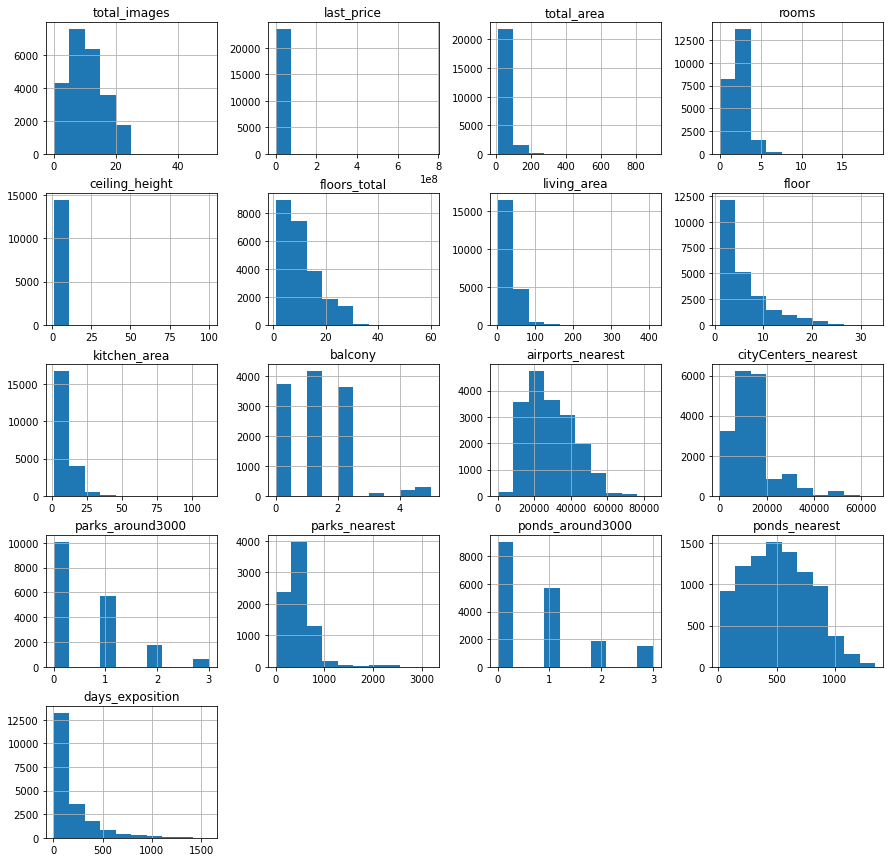

In [2]:
data.info() #получим информацию о количестве значений в каждом столбце, а также форматах данных
data.head(10) #посмотрим на первые 10 строк
data.hist(figsize=(15,15)); #построим гистаграммы для всех значений в таблице

**Во многих столбцах обнаружено большое количество пропусков. Например, в то время как в столбцах total_image, last_price, total_area и first_day_exposition 23699 значений, в столбце is_apartment их всего 2775. Также как видно в таблице с общей информацией о датафрейме, очень много пропусков в столбцах с географическими данными (parks_neareast, ponds_nearest): они , скорее всего, являются технической ошибкой. Удалим пропуски в тех столбцах, где это возможно.**

In [3]:
data.shape[0] #проверяется число строк в исходной версии датафрейма для того, чтобы потом следить за числом удаленных значений

23699

### Предобработка данных

#####  Работа с пропущенными значениями в столбцах

**Используя комбинацию двух методов, сначала выведем на экран количество пропусков в каждом столбце.**

In [4]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [5]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

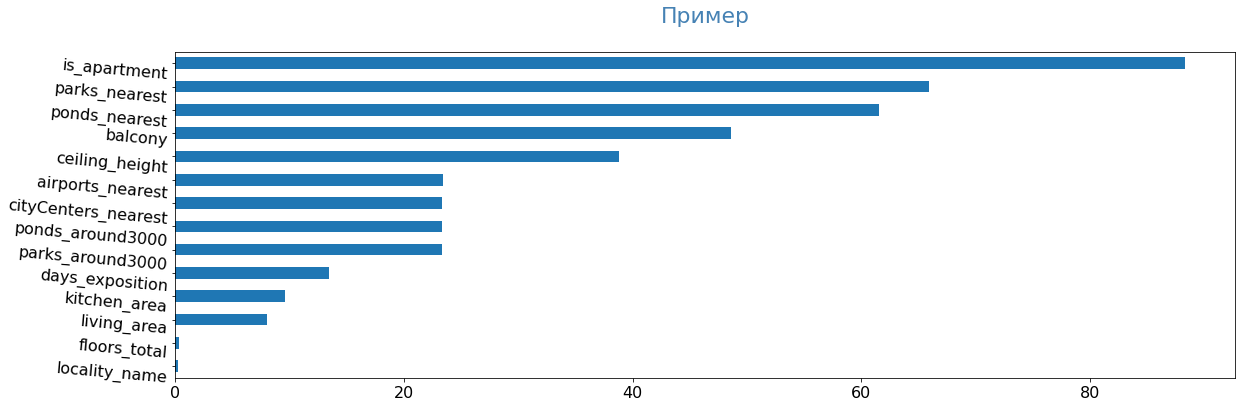

In [6]:
pass_value_barh(data)

**Перейдем к заполнению пропусков в столбцах, где это возможно. Одним из них является столбец с высотой потолков в квартирах ('ceiling_height'). Высота потолка в квартире зависит от типа здания, года его строительства и,как следствие, места расположения. Замена всех пропусков медианным значением по столбцу создает риск искажения данных, в связи с чем уместнее всего будет производить замены по медианному значению высоты потолка в населенных пунктах.**

**Перед заполненением пропусков в столбце с высотой потолков посмотрим на стандартное отклонение и дисперсию значений в нем. Как видно ниже, у значений существенное отклонение от среднего арифметического.**

In [7]:
data['ceiling_height'].describe()


count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

**Узнаем количество пропусков в столбсце с высотой потолков для того, чтобы в дальнейшем сравнить его с результатом замены пропусков.**

In [8]:
len(data[data['ceiling_height'].isna()])

9195

**Заполним пропуски в столбце ´ceiling_height' медианным значением высоты потолка в каждом отдельном населенном пункте при помощи метода .transform().**

In [9]:
data['ceiling_height'] = data['ceiling_height'].fillna(data.groupby('locality_name')['ceiling_height'].transform('median'))
len(data[data['ceiling_height'].isna()])

156

**Посмотрим на дисперсию после замены пропусков. Как мы видим, значения тяготеют к среднему арифметическому.**

In [10]:
data['ceiling_height'].describe()

count    23543.000000
mean         2.734102
std          1.012723
min          1.000000
25%          2.550000
50%          2.700000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

**Узнаем все уникальные значения в столбце floors_total.**

In [11]:
data['floors_total'].unique()


array([16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,
       23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., nan, 20.,
       28., 36., 21., 35., 34., 60.,  1., 29., 33., 52., 37.])

**Поскольку в столбце есть строки с одноэтажными зданиями, пропущенные значения не означают, что в здании всего один этаж. Пропуски можно объяснить человеческим фактором: при заполнении объявления они могли забыть заполнить это поле. Мы не можем никак найти замену пропускам, так как число этажей - это уникальные значение,но мы также не можем поставить нули: это исказит данные. Поэтому будет уместным удалитьстроки  с пропусками.**

In [12]:
data = data[сdata['floors_total'].isna()]
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height            154
floors_total                0
living_area              1870
floor                       0
is_apartment            20838
studio                      0
open_plan                   0
kitchen_area             2231
balcony                 11480
locality_name              48
airports_nearest         5532
cityCenters_nearest      5509
parks_around3000         5508
parks_nearest           15568
ponds_around3000         5508
ponds_nearest           14552
days_exposition          3172
dtype: int64

In [13]:
data.shape[0]

23613

**В столбцах is_apartment и balcony представлены данные, вписанные самими пользователями. Пропуски значений в этом случае указывают не на техническую ошибку, а на то, что пользователи при создании объявления, скорее всего, проигнорировали поля для заполнения этой информации:раз нет балкона, то и не будет информации о нем. Следовательно, будет правильным заполнить пропуски "0". Аналогично поступим с пропусками в is_apartment.**

In [14]:
data['balcony']=data['balcony'].fillna(value='0')
len(data[data['balcony'].isna()])

0

In [15]:
data['is_apartment']=data['is_apartment'].fillna(value='0')
len(data[data['is_apartment'].isna()])

0

In [16]:
data.query('total_area * 0.9 <= (living_area + kitchen_area)')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
41,16,7900000.0,74.0,2016-05-04T00:00:00,3,2.70,14.0,59.0,8,False,...,12.0,5.0,Санкт-Петербург,37715.0,12612.0,1.0,725.0,1.0,759.0,179.0
171,6,3800000.0,49.0,2019-02-22T00:00:00,2,2.50,9.0,38.0,8,0,...,10.0,1.0,посёлок Шушары,18471.0,24272.0,0.0,NaN,0.0,NaN,11.0
184,7,2600000.0,30.2,2018-02-14T00:00:00,1,2.65,9.0,26.1,5,0,...,6.2,0,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
220,8,3890000.0,37.0,2018-07-09T00:00:00,1,2.50,25.0,28.0,6,0,...,9.0,0,Санкт-Петербург,25408.0,16166.0,0.0,NaN,0.0,NaN,28.0
319,19,4850000.0,59.7,2015-03-19T00:00:00,3,2.50,5.0,47.4,4,0,...,6.4,1.0,Санкт-Петербург,43095.0,15599.0,0.0,NaN,0.0,NaN,974.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23216,15,10150000.0,114.0,2015-01-21T00:00:00,4,2.70,5.0,90.2,4,0,...,16.0,0,Санкт-Петербург,26259.0,4961.0,0.0,NaN,2.0,838.0,1052.0
23297,10,1850000.0,48.2,2019-03-13T00:00:00,2,2.50,5.0,42.2,2,0,...,6.0,1.0,Высоцк,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23328,12,4299000.0,54.0,2016-11-25T00:00:00,2,2.50,14.0,40.0,8,0,...,10.0,0.0,Колпино,25612.0,31399.0,0.0,NaN,0.0,NaN,343.0
23521,13,8500000.0,65.0,2018-11-01T00:00:00,2,2.70,4.0,44.0,2,0,...,15.3,0,Санкт-Петербург,22276.0,3996.0,1.0,627.0,0.0,NaN,NaN


**Заменим пропуски в столбце 'kitchen_area' для студий и кювартир с открытой планировкой на 0.**

In [17]:
kitchen_no_data = (data['open_plan'] == True) | (data['studio'] == True)
data.loc[kitchen_no_data, 'kitchen_area'] = data.loc[kitchen_no_data, 'kitchen_area'].fillna(0)

In [18]:
len(data[data['kitchen_area'].isna()]) #проверяем число пропусков после замен

2018

**Мы избавились от 218 пропусков в столбце kitchen_area. Как мы видим, после применения логической индексации в чем 2 тыс. строках остались пропуски. Мы могли бы их заменить на медианное значение площади кухни в зависимости от  количества комнат в квартире, однако это могло бы отразиться на структуре данных и, как следствие, привело бы к неверному их анализу.**

**В столбце с общей жилой площадью 1870 пропусков, что составляет около 7.9 % всех значений. Однако по аналогии со столбцом, содержащим значения площади кухни, замена пропусков грозит искажением данных. В частности, есть существенный  риск завышения среднего значения площади. В такой ситуации в датафрейме могут появиться строки с аномальной площадью,когда общая площадь квартиры практически равна суммарной площади кухни и жилой зоны: это невозможно, так как в каждой квартире имеются санузел, прихожая и коридор.**

In [19]:
data.shape[0]

23613

**Как мы видим ниже, у 481 строки сумма значений в 'living_area' и 'kitchen_area' в практически равна общей площади квартиры, что можно считать аномалией. Они составляют 2 % от общего числа значений, что не критично. На данном этапе мы не можем от них отказаться. В дальнейшем при работе с аномальными значениями, возможно, мы избавимся от части из них.**

In [20]:
data.query('total_area * 0.9 <= (living_area + kitchen_area)')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
41,16,7900000.0,74.0,2016-05-04T00:00:00,3,2.70,14.0,59.0,8,False,...,12.0,5.0,Санкт-Петербург,37715.0,12612.0,1.0,725.0,1.0,759.0,179.0
171,6,3800000.0,49.0,2019-02-22T00:00:00,2,2.50,9.0,38.0,8,0,...,10.0,1.0,посёлок Шушары,18471.0,24272.0,0.0,NaN,0.0,NaN,11.0
184,7,2600000.0,30.2,2018-02-14T00:00:00,1,2.65,9.0,26.1,5,0,...,6.2,0,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
220,8,3890000.0,37.0,2018-07-09T00:00:00,1,2.50,25.0,28.0,6,0,...,9.0,0,Санкт-Петербург,25408.0,16166.0,0.0,NaN,0.0,NaN,28.0
319,19,4850000.0,59.7,2015-03-19T00:00:00,3,2.50,5.0,47.4,4,0,...,6.4,1.0,Санкт-Петербург,43095.0,15599.0,0.0,NaN,0.0,NaN,974.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23216,15,10150000.0,114.0,2015-01-21T00:00:00,4,2.70,5.0,90.2,4,0,...,16.0,0,Санкт-Петербург,26259.0,4961.0,0.0,NaN,2.0,838.0,1052.0
23297,10,1850000.0,48.2,2019-03-13T00:00:00,2,2.50,5.0,42.2,2,0,...,6.0,1.0,Высоцк,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23328,12,4299000.0,54.0,2016-11-25T00:00:00,2,2.50,14.0,40.0,8,0,...,10.0,0.0,Колпино,25612.0,31399.0,0.0,NaN,0.0,NaN,343.0
23521,13,8500000.0,65.0,2018-11-01T00:00:00,2,2.70,4.0,44.0,2,0,...,15.3,0,Санкт-Петербург,22276.0,3996.0,1.0,627.0,0.0,NaN,NaN


**Название местности является уникальным значением. В таком случае мы не можем найти замены пропускам, в связи с чем и удаляем строки с пропусками в столбце locality_name.**

In [21]:
data.shape[0]

23613

In [22]:
data = data[~data['locality_name'].isna()]
data.isna().sum()


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height            120
floors_total                0
living_area              1865
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2009
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64

**Перейдем к заполнению пропусков в столбце c числом парков в радиусе 3 км.**

In [23]:
data['parks_around3000'].unique()
data['parks_around3000'].value_counts()

0.0    10039
1.0     5647
2.0     1736
3.0      643
Name: parks_around3000, dtype: int64

**Поскольку эти географические данные получаются автоматически, мы можем говорить о том, что пропуск означает отсутствие прудов в радиусе 3 км. В связи с этим замена пропусков будет уместной.**

In [24]:
data['parks_around3000']=data['parks_around3000'].fillna(value=0)
len(data[data['parks_around3000'].isna()])

0

In [25]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23445 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           21700 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  object 
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          21556 non-null  float64
 13  balcony               23565 non-null  object 
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

**Перейдем к столбцу c информацией о наличии пруда в радиусе 3 км.**

In [26]:
data['ponds_around3000'].value_counts()

0.0    9029
1.0    5662
2.0    1883
3.0    1491
Name: ponds_around3000, dtype: int64

**Расстояние до парка - это уникальное значение. Мы не можем заменить пропуски медианным значением столбца. В данном случае речь о технической природе пропусков:вся информация в этом столбце получена автоматически на основании картографических данных.Оставим пропуски.**

**Заполняем пропуски нулями по аналогии со столбцом 'parks_around3000'.**

In [27]:
data['ponds_around3000']=data['ponds_around3000'].fillna(value=0)
len(data[data['ponds_around3000'].isna()])

0

**В столбцах airports_nearest, cityCenters_nearest и days_exposition замена пропусков не производится, поскольку в них содержатся уникальные значения.**

In [28]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height            120
floors_total                0
living_area              1865
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2009
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000            0
parks_nearest           15535
ponds_around3000            0
ponds_nearest           14529
days_exposition          3171
dtype: int64

In [29]:
data.shape[0]

23565

##### Изменение типов данных

**Изменим в ряде столбцов тип данных.**

**В столбцах last_price, floors_total, balcony, parks_around3000, ponds_around3000,airports_nearest, cityCenters_nearest,а также parks_nearest, ponds_nearest вещественный тип данных. Замена необходима по той причине, что в некототрых столбцах не могут быть вещественные значения: количество этажей и балконов, а также ближайших прудов и парков - это всегда целые числа. В других столбцах замена будет произведена по причине того, что унификация типа данных может обезопасить нас от возможных ошибок при дальнейшем анализе. Поэтому изменим вещественный тип данных на целочисленный, поместив указанные столбцы в список.**


In [30]:
list1 = ['last_price','balcony', 'parks_around3000', 'floors_total','ponds_around3000','airports_nearest',
         'cityCenters_nearest','ponds_nearest']
for i in list1:
    data[i] = data[i].astype('int',errors='ignore')

**Перейдем к столбцу с количеством дней с момента публикации объявления. В нем представлены данные в типе object, что является ошибкой, поскольку в столбце отображены цифры. По этой причине меняем тип на целочисленный с учетом наличия пропусков.**

In [31]:
data['days_exposition'] = data['days_exposition'].astype('int', errors='ignore')

**В столбце 'is_apartment' нужно поменять тип данных с object на булевый.**

In [32]:
data['is_apartment']=data['is_apartment'].astype('bool')

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  int64  
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23445 non-null  float64
 6   floors_total          23565 non-null  int64  
 7   living_area           21700 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  bool   
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          21556 non-null  float64
 13  balcony               23565 non-null  int64  
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

##### Устранение дубликатов

**Выведем на экран все уникальные значения столбца с названиями населенных пунктов.**

In [34]:
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

**Как мы видим, одни и те же населенные пункты могут быть записаны по-разному. Например, в столбце встречается как и просто название населенного пункта с его типом (например, поселок Лебяжье), так и его написание в расширенном виде (поселок городского типа). Исправим это,удалив расширенные названия поселков.**

In [35]:
wrong_names = (
    [ 'посёлок городского типа', 'поселок городского типа', 'посёлок городского типа', 'городской посёлок', 
     'городской поселок', 
     'поселок при железнодорожной станции', 'поселок станции', 'коттеджный поселок', 'посёлок', 'деревня']
)
for substr in wrong_names:
    data['locality_name'] = data['locality_name'].str.replace(substr,'поселок')
data['locality_name'].unique()

array(['Санкт-Петербург', 'поселок Шушары', 'поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'поселок Кудрово', 'Коммунар', 'Колпино',
       'поселок Красный Бор', 'Гатчина', 'поселок Фёдоровское', 'Выборг',
       'Кронштадт', 'Кировск', 'поселок Новое Девяткино',
       'поселок Металлострой', 'поселок Лебяжье', 'поселок Сиверский',
       'поселок Молодцово', 'поселок Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'поселок Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'поселок Куттузи', 'поселок Аннино',
       'поселок Ефимовский', 'поселок Плодовое', 'поселок Заклинье',
       'поселок Торковичи', 'поселок Первомайское', 'Красное Село',
       'поселок Понтонный', 'Сясьстрой', 'поселок Старая',
       'поселок Лесколово', 'поселок Новый Свет', 'Сланцы',
       'село Путилово', 'Ивангород', 'Мурино', 'Шлиссельбург',
       'Никольское', 'Зелено

In [36]:
# check
data['locality_name'].nunique()

316

##### Устранение аномальных значений

In [37]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,565.00","23,565.00","23,445.00","20,394.00","23,565.00","21,700.00","21,556.00","23,565.00","23,565.00"
min,0.00,12.00,1.00,1.00,"12,190.00",2.00,0.00,1.00,1.00
max,19.00,900.00,100.00,"1,580.00","763,000,000.00",409.70,112.00,33.00,60.00


**Посмотрим на уникальные значения в столбце с высотой потолка, чтобы выявить аномальные значения. Как видно ниже, встречаются такие аномально большие значения как 26-27 м, а также аномальные низкие - 1.3, 2.5 м т.д.**

In [38]:
data['ceiling_height'].unique()

array([  2.7  ,   2.63 ,   3.03 ,   2.6  ,   2.64 ,   2.5  ,   2.67 ,
         2.55 ,   2.56 ,   3.05 ,   2.75 ,   2.9  ,   2.56 ,   2.8  ,
         3.   ,   2.65 ,   3.2  ,   2.61 ,     nan,   3.25 ,   3.45 ,
         2.77 ,   2.85 ,   2.525,   2.57 ,   4.15 ,   3.5  ,   3.3  ,
         2.71 ,   4.   ,   2.47 ,   2.73 ,   2.84 ,   3.1  ,   2.34 ,
         3.4  ,   2.52 ,   3.06 ,   2.72 ,   2.54 ,   2.51 ,   2.78 ,
        13.85 ,   2.76 ,  25.   ,   2.58 ,   3.7  ,   5.2  ,   2.87 ,
         2.66 ,   2.59 ,   2.   ,   2.45 ,   3.6  ,   3.9  ,   2.92 ,
         3.11 ,   3.13 ,   3.8  ,   3.15 ,   3.55 ,   3.16 ,   3.62 ,
         3.12 ,   2.53 ,   2.74 ,   2.96 ,   2.46 ,   5.3  ,   5.   ,
         2.79 ,   2.95 ,   4.06 ,   2.94 ,   3.82 ,   3.54 ,   3.53 ,
         2.83 ,   4.7  ,   2.4  ,   3.38 ,   3.01 ,   5.6  ,   3.65 ,
         3.18 ,   3.35 ,   2.3  ,   3.57 ,   2.48 ,   2.515,   2.62 ,
         2.82 ,   2.65 ,   3.98 ,   3.83 ,  27.   ,   3.52 ,   3.95 ,
         3.75 ,   2.

**Обратимся к логической индексации для удаления аномально высоких и аномально низких значений. Оставим только те значения, которые больше 2.4 м и меньше 3.5 м.**

In [39]:
data = data.loc[(data['ceiling_height'] >= 2.4) & (data['ceiling_height'] <= 3.5)]
data['ceiling_height'].unique()

array([2.7  , 2.63 , 3.03 , 2.6  , 2.64 , 2.5  , 2.67 , 2.55 , 2.56 ,
       3.05 , 2.75 , 2.9  , 2.56 , 2.8  , 3.   , 2.65 , 3.2  , 2.61 ,
       3.25 , 3.45 , 2.77 , 2.85 , 2.525, 2.57 , 3.5  , 3.3  , 2.71 ,
       2.47 , 2.73 , 2.84 , 3.1  , 3.4  , 2.52 , 3.06 , 2.72 , 2.54 ,
       2.51 , 2.78 , 2.76 , 2.58 , 2.87 , 2.66 , 2.59 , 2.45 , 2.92 ,
       3.11 , 3.13 , 3.15 , 3.16 , 3.12 , 2.53 , 2.74 , 2.96 , 2.46 ,
       2.79 , 2.95 , 2.94 , 2.83 , 2.4  , 3.38 , 3.01 , 3.18 , 3.35 ,
       2.48 , 2.515, 2.62 , 2.82 , 2.65 , 2.88 , 3.24 , 3.36 , 3.08 ,
       3.07 , 3.37 , 3.09 , 3.26 , 3.34 , 2.81 , 3.44 , 2.97 , 3.14 ,
       2.725, 2.68 , 2.6  , 3.22 , 3.27 , 2.675, 2.93 , 3.46 , 3.47 ,
       3.33 , 2.625, 3.32 , 2.615, 2.98 , 2.86 , 3.17 , 3.28 , 3.04 ,
       3.23 , 3.02 , 3.21 , 3.43 , 2.575, 2.555, 3.39 , 2.69 , 3.31 ,
       3.42 , 2.99 , 3.49 , 2.91 , 3.29 , 2.89 , 2.49 , 3.48 ])

In [40]:
data.shape[0]

23104

**Перейдем к столбцу, содержащему значения площадей квартиры.**

In [41]:
data.kitchen_area.value_counts().to_frame()

,kitchen_area
6.00,1276
10.00,1234
8.00,1092
9.00,1068
7.00,1051
...,...
13.41,1
34.51,1
8.18,1
14.65,1


**Как видно на гистограмме, у большинства квартир в выборке площадь кухни составляет 5, 9 и 11 кв.м. Довольно редко встречаются объекты с площадью квартиры менее 5, а также более 45 кв.м.**

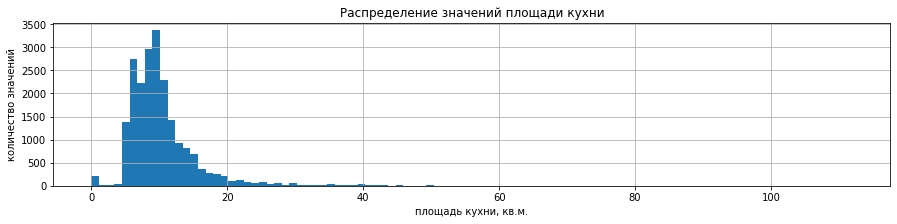

In [42]:
data.kitchen_area.hist(bins=100, figsize=(15,3));
plt.title('Распределение значений площади кухни')
plt.xlabel('площадь кухни, кв.м.')
plt.ylabel('количество значений')
plt.show()


**Убедимся в том, что удаление всех значений свыше 50 кв.м. не грозит искажением данных.Для этого построим гистограмму распределения значений от 50 до 100 кв.м.**

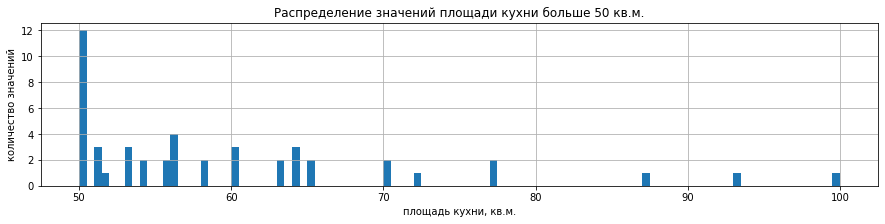

In [43]:
data.kitchen_area.hist(bins=100, figsize=(15,3), range=(50,100));
plt.title('Распределение значений площади кухни больше 50 кв.м.')
plt.xlabel('площадь кухни, кв.м.')
plt.ylabel('количество значений')
plt.show()


**Как видно выше, в датафрейме очень мало значений площади квартиры выше 50 кв.м. Значим можем смело их удалить.В столбце kitchen_area 2009 пропусков,фильтрация производится с учетом этого.**

In [44]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23104 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23104 non-null  int64  
 1   last_price            23104 non-null  int64  
 2   total_area            23104 non-null  float64
 3   first_day_exposition  23104 non-null  object 
 4   rooms                 23104 non-null  int64  
 5   ceiling_height        23104 non-null  float64
 6   floors_total          23104 non-null  int64  
 7   living_area           21287 non-null  float64
 8   floor                 23104 non-null  int64  
 9   is_apartment          23104 non-null  bool   
 10  studio                23104 non-null  bool   
 11  open_plan             23104 non-null  bool   
 12  kitchen_area          21148 non-null  float64
 13  balcony               23104 non-null  int64  
 14  locality_name         23104 non-null  object 
 15  airports_nearest   

In [45]:
data = data.query('kitchen_area <= 50 or kitchen_area.isna()')

In [46]:
data.shape[0]

23065

In [47]:
data = data.query('kitchen_area > 4 or kitchen_area.isna()')

In [48]:
data.shape[0]

22805

<div class="alert alert-dan
            ger">
<font size="4"><b>❌ Комментарий ревьюера </b></font>
    <br /> 
    <font size="3", color = "black">
<br />

    data = data.loc[(data['kitchen_area'] >= 6.0) & (data['kitchen_area'] <= 40.0)]                                                                                  
Было 23327 записей, осталось 21521
                                                                                  
слишком жесткое условие, стоит посмотреть на гистограммы, чтобы не потерять слишком много записей


In [49]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22805 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          22805 non-null  int64  
 1   last_price            22805 non-null  int64  
 2   total_area            22805 non-null  float64
 3   first_day_exposition  22805 non-null  object 
 4   rooms                 22805 non-null  int64  
 5   ceiling_height        22805 non-null  float64
 6   floors_total          22805 non-null  int64  
 7   living_area           21001 non-null  float64
 8   floor                 22805 non-null  int64  
 9   is_apartment          22805 non-null  bool   
 10  studio                22805 non-null  bool   
 11  open_plan             22805 non-null  bool   
 12  kitchen_area          20849 non-null  float64
 13  balcony               22805 non-null  int64  
 14  locality_name         22805 non-null  object 
 15  airports_nearest   

In [50]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1804
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             1956
balcony                     0
locality_name               0
airports_nearest         5259
cityCenters_nearest      5239
parks_around3000            0
parks_nearest           15052
ponds_around3000            0
ponds_nearest           14100
days_exposition          3048
dtype: int64

In [51]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.01, .5, .90, .9976])  
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.01,1.00,28.00,2.50,4.00,"1,080,400.00",13.00,5.00,1.00,2.00
0.5,2.00,52.00,2.70,95.00,"4,650,000.00",30.00,9.10,4.00,9.00
0.9,3.00,92.00,3.00,459.00,"10,600,000.00",54.00,15.50,13.00,22.00
0.9976,7.00,274.74,3.50,"1,313.59","65,037,362.79",166.88,42.80,25.00,27.00


**Сначала избавимся от аномальных значений в столбце с количеством комнат. Для данного исследования 7-, 8-комнатные квартиры - это уникальные значения. Такие объекты недвжимости не состаавляют большинство. От них можно избавиться без риска для структуры данных.**

In [52]:
# check
data.rooms.value_counts().to_frame()

,rooms
1,7871
2,7728
3,5646
4,1119
5,283
6,89
7,43
8,9
9,8
10,3


In [53]:
data = data.loc[(data['rooms'] <= 6)]            

In [54]:
data.shape[0]

22736

**Перейдем к столбцу с общей площадью квартиры.**

**Посмотрим на график распределения значений. Большинство квартир имеют площадь от 40 до 50 кв. м. Минимальное число значений наблюдается среди квартир с площадью менее 5-25 кв.м., а также более 250 кв.м.**

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />т.е. все квартиры более 250-ти квадратных метров можно считать редкостями
        
особенно это заметно на втором графике, где мы подробно рассматриваем промежуток от 180 кв. метров до 500

**Обратимся к графику распределения значений от 5 до 25 кв.м.**

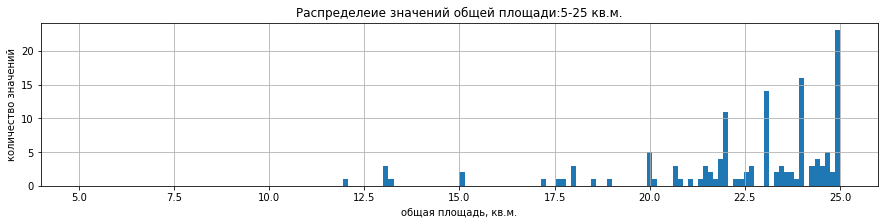

In [55]:
data.total_area.hist(bins = 150, figsize = (15,3), range = (5,25));
plt.title('Распределеие значений общей площади:5-25 кв.м.')
plt.xlabel('общая площадь, кв.м.')
plt.ylabel('количество значений')
plt.show()


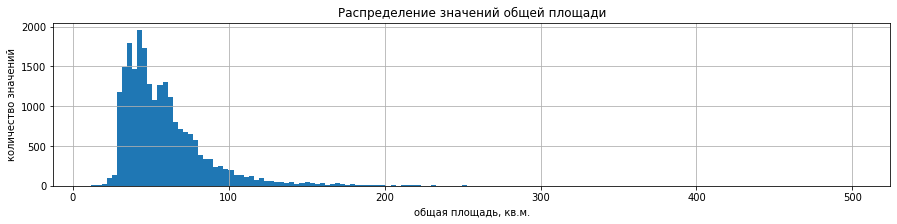

In [56]:
# check
data.total_area.hist(bins = 150, figsize = (15,3))
plt.title('Распределение значений общей площади')
plt.xlabel('общая площадь, кв.м.')
plt.ylabel('количество значений')
plt.show()


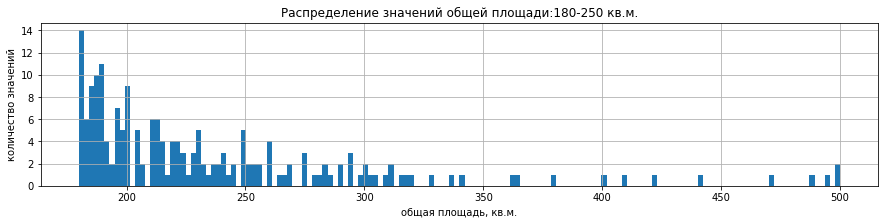

In [57]:
# check
data.total_area.hist(bins = 150, figsize = (15,3), range = (180,500))
plt.title('Распределение значений общей площади:180-250 кв.м.')
plt.xlabel('общая площадь, кв.м.')
plt.ylabel('количество значений')
plt.show()


In [58]:
data = data.loc[(data['total_area'] >= 10) & (data['total_area'] <= 250)]
            

In [59]:
data.shape[0]

22681

In [60]:
data.days_exposition.describe()

count    19668.000000
mean       180.368568
std        219.193022
min          1.000000
25%         45.000000
50%         95.000000
75%        230.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [61]:
data.days_exposition.value_counts().to_frame().head(20)

,days_exposition
45.0,830
60.0,530
7.0,221
30.0,199
90.0,186
4.0,168
3.0,154
5.0,143
14.0,138
11.0,133


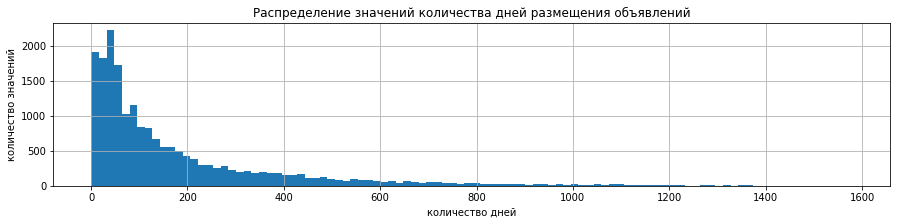

In [62]:
data.days_exposition.hist(bins=100, figsize=(15,3))
plt.title('Распределение значений количества дней размещения объявлений')
plt.xlabel('количество дней')
plt.ylabel('количество значений')
plt.show()

 **Продажа квартиры редко занимает больше года. Поэтому изучим распределение значений от 430 до 1580 дней. Как видно на гистограмме, в выборке есть объекты недвижимости, чья продажа заняла более 1200 дней, представлены крайне редко редко. Удалим их.**

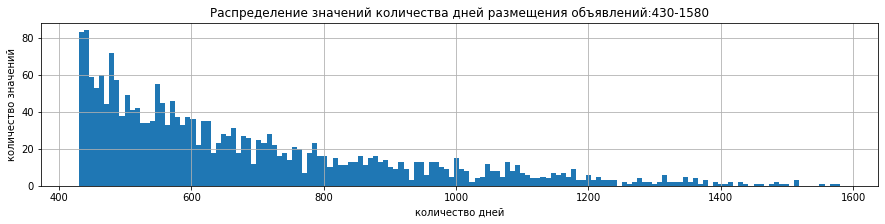

In [63]:
data.days_exposition.hist(bins=150, figsize=(15,3), range= (430,1580))
plt.title('Распределение значений количества дней размещения объявлений:430-1580')
plt.xlabel('количество дней')
plt.ylabel('количество значений')
plt.show()

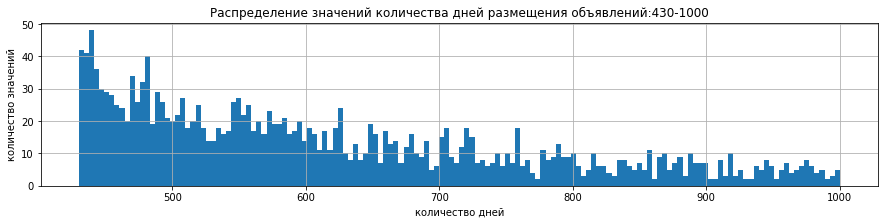

In [64]:
data.days_exposition.hist(bins=150, figsize=(15,3), range= (430,1000))
plt.title('Распределение значений количества дней размещения объявлений:430-1000')
plt.xlabel('количество дней')
plt.ylabel('количество значений')
plt.show()

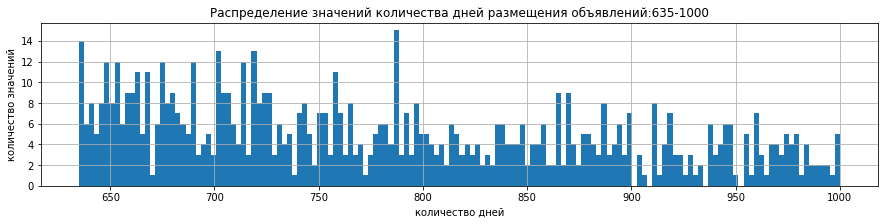

In [65]:
data.days_exposition.hist(bins=150, figsize=(15,3), range= (635,1000))
plt.title('Распределение значений количества дней размещения объявлений:635-1000')
plt.xlabel('количество дней')
plt.ylabel('количество значений')
plt.show()

In [66]:
data = data.query('days_exposition < 730 or days_exposition.isna()')

In [67]:
data.shape[0]

21965

**Перейдем к удалению аномальных значений в столбце с ценой квартиры на момент её продажи.**

**Сначала ознакомимся с  50 самыми распространенных значений. Как видно, это квартиры стоимостью более 2 млн. рвблей.**

In [68]:
data.last_price.value_counts().to_frame().head(50)

,last_price
4500000,338
3500000,272
4000000,254
4300000,252
4200000,246
3600000,244
3800000,228
3200000,225
3700000,223
3300000,222


**Построим гистограмму для ознакомления с распределением всех значений в столбце. Видно, что квартиры стоимостью больше 30 млн. рублей встречаются в датафрейме редко.Удалив их, мы не рискуем в дальнейшем исказить анализ данных.**

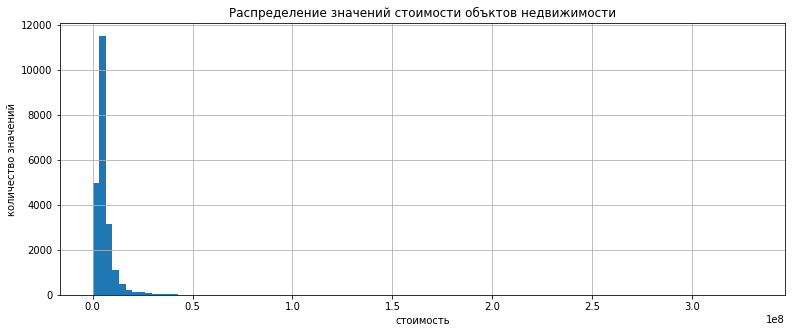

In [69]:
data.last_price.hist(bins=100,figsize=(13,5))
plt.title('Распределение значений стоимости объктов недвижимости')
plt.xlabel('стоимость')
plt.ylabel('количество значений')
plt.show()

**Изучим распределение значений от минимального (около 12 тыс. рублей) до 1 млн 100 тыс. рублей. Как видно на гистограмме, значения меньше 400 тыс. рублей встречаются редкое, следовательно, мы можем их удалить.**

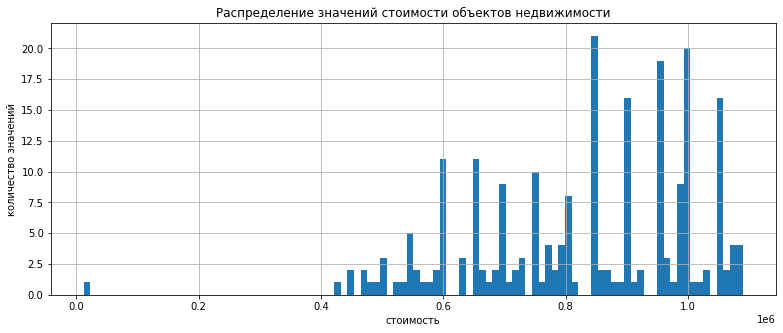

In [70]:
data.last_price.hist(bins=100,figsize=(13,5), range=(12000,1090000))
plt.title('Распределение значений стоимости объектов недвижимости')
plt.xlabel('стоимость')
plt.ylabel('количество значений')
plt.show()

**Плсмотрим на распределение значений от 10 до 40 млн. рублей. Квартиры стоимостью 30 млн. действительно встречаются значительно реже чем те, которые стоят 10 млн. Мы убедились в том, что 25 млн. руб. - это верхняя граница значений.**

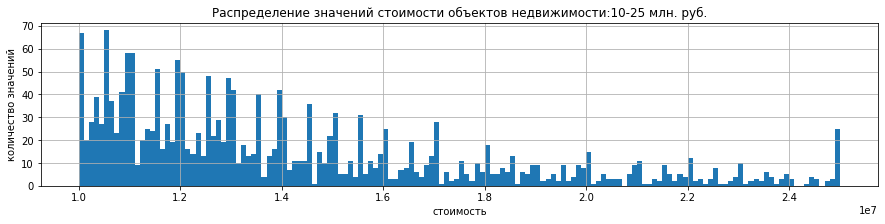

In [71]:
data.last_price.hist(bins=150,figsize=(15,3),range=(10000000, 25000000))
plt.title('Распределение значений стоимости объектов недвижимости:10-25 млн. руб.')
plt.xlabel('стоимость')
plt.ylabel('количество значений')
plt.show()

In [72]:
data = data.loc[(data['last_price'] >= 400000) & (data['last_price'] <= 25000000)]

In [73]:
data.shape[0]

21676

**Перейдем у странению аномальных значений в столбце со значениями жилой площади.**

In [74]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"21,676.00","21,676.00","21,676.00","18,751.00","21,676.00","19,971.00","19,812.00","21,676.00","21,676.00"
min,1.00,12.00,2.40,1.00,"430,000.00",2.00,4.10,1.00,1.00
max,6.00,250.00,3.50,729.00,"25,000,000.00",171.00,50.00,33.00,60.00


**Обратимся к гистограмме распределения значений. Как мы видим, у большинства квартир жилая площадь составляет около 19-20 кв.м. Значения менее 14 кв.м., а также более 105 кв.м. редко встречаются.** 

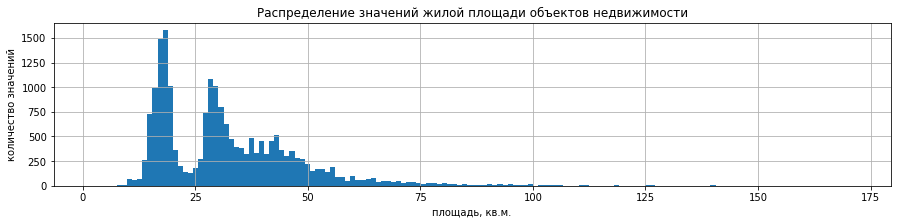

In [75]:
data.living_area.hist(bins=150, figsize=(15,3))
plt.title('Распределение значений жилой площади объектов недвижимости')
plt.xlabel('площадь, кв.м.')
plt.ylabel('количество значений')
plt.show()

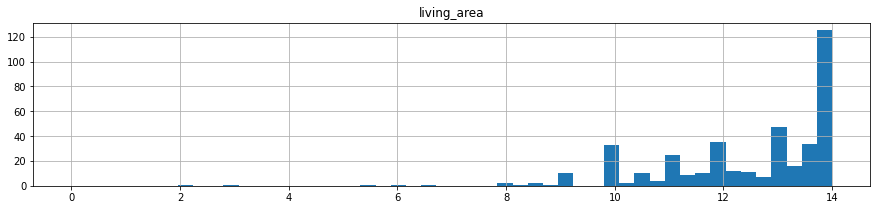

In [76]:
# check
data.hist(column = 'living_area', bins = 50, figsize = (15,3), range = (0,14));

In [77]:
data = data.query('living_area > 13 or living_area.isna()')

In [78]:
data = data.query('living_area <= 105 or living_area.isna()')

In [79]:
data.shape[0]

21378

**Перейдем к столбцу с общим числом  этажей в здании.**

In [80]:
data.floors_total.value_counts().to_frame()

,floors_total
5,5270
9,3586
16,1290
12,1290
10,1089
4,1020
25,1002
17,774
6,705
3,556


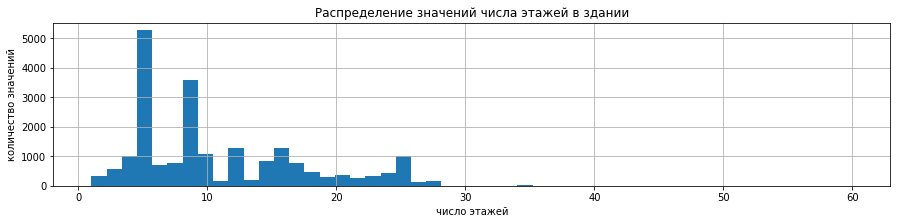

In [81]:
data.floors_total.hist(bins=50, figsize=(15,3))
plt.title('Распределение значений числа этажей в здании')
plt.xlabel('число этажей')
plt.ylabel('количество значений')
plt.show()

In [82]:
data = data.loc[(data['floors_total'] <= 27)]

In [83]:
data.shape[0]

21330

In [84]:
data.reset_index(drop=True) #сдеалем переиндексацию 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.00,2019-03-07T00:00:00,3,2.70,16,51.0,8,True,...,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
1,7,3350000,40.40,2018-12-04T00:00:00,1,2.63,11,18.6,1,True,...,11.0,2,поселок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
2,10,5196000,56.00,2015-08-20T00:00:00,2,2.70,5,34.3,4,True,...,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0
3,2,10000000,100.00,2018-06-19T00:00:00,2,3.03,14,32.0,13,True,...,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0
4,10,2890000,30.40,2018-09-10T00:00:00,1,2.60,12,14.4,5,True,...,9.1,0,поселок Янино-1,NaN,NaN,0,NaN,0,NaN,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21325,11,9470000,72.90,2016-10-13T00:00:00,2,2.75,25,40.3,7,True,...,10.6,1,Санкт-Петербург,19424.0,4489.0,0,NaN,1,806.0,519.0
21326,2,1350000,30.00,2017-07-07T00:00:00,1,2.60,5,17.5,4,True,...,6.0,0,Тихвин,NaN,NaN,0,NaN,0,NaN,413.0
21327,9,4600000,62.40,2016-08-05T00:00:00,3,2.60,9,40.0,8,True,...,8.0,0,Петергоф,45602.0,34104.0,1,352.0,1,675.0,239.0
21328,14,3100000,59.00,2018-01-15T00:00:00,3,2.50,5,38.0,4,True,...,8.5,0,Тосно,NaN,NaN,0,NaN,0,NaN,45.0


**Заполнение пропусков в тех случаях, когда это являлось возможным, а также изменение типа данных в некоторых столбцах и удаление аномальных значений стали первым шагом на пути к проведению точного анализа данных. В целом, благодаря совершенным выше шагам повышается степень точности данных, что важно для дальнейших их интерпретации при помощи визуализации.**

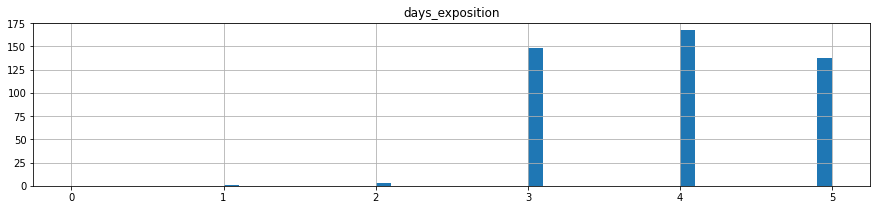

In [85]:
# check
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5));

### Посчитайте и добавьте в таблицу новые столбцы

##### Добавление столбцов

**Добавим столбец с ценой одного квадратногометра. Для этого поделим значения цены квартир на момент снятия публикации на общую их площадь.**

In [86]:
data['price_per_square_metre'] = data['last_price'] // data['total_area']


**Теперь добавим столбец с днем недели публикации. Для этого будем использовать столбец с датой публикации.**

In [87]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['exposition_weekday'] = data['first_day_exposition'].dt.weekday

**Следующий шаг - это добавление столбца с месяцем публикацаии. Также обращаемся к столбцу first_day_exposition.**

In [88]:
data['exposition_month'] = data['first_day_exposition'].dt.month


**Добавим столбец с годом публикации. Для этого снова обратимся к столбцу с датой публикации объявлений.**

In [89]:
data['exposition_year'] = data['first_day_exposition'].dt.year


**С целью добавления столбца с типом этажа применим функцию для одной строки.**

In [90]:
data['floors_total'].unique()

array([16, 11,  5, 14, 12, 24, 27,  9,  6, 17, 25,  3, 23, 19, 18, 26, 22,
        4,  2, 10,  7, 13, 15,  8, 20, 21,  1])

In [91]:
def floor_type(data):
    floor=data['floor']
    if floor == 1:
        return 'первый'
    elif  1 < floor < data['floors_total']:
        return 'другой'
    return 'последний'
data['floor_type'] = data.apply(floor_type, axis=1)



In [92]:
# check
data['floor_type'].value_counts()

другой       15739
последний     2940
первый        2651
Name: floor_type, dtype: int64

**Последний столбцей, который мы добавим в датафрейм, содержится значения расстояния до центра города в метрах. Для удобства округлим их.**

In [93]:
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] // 1000).round()


**Получим информацию об датафрейме с учетом новых столбцов и выведем на экран его первые строки. Как видно, в датафрейм было добавлено 6 новых столбцов.Добавление столбцом поможет углубить анализ зависимостей различных факторов при продаже объекта недвижмости.**

In [94]:
data.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_metre,exposition_weekday,exposition_month,exposition_year,floor_type,cityCenters_nearest_km
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,True,...,482.0,2,755.0,NaN,120370.0,3,3,2019,другой,16.0
1,7,3350000,40.4,2018-12-04,1,2.63,11,18.6,1,True,...,NaN,0,NaN,81.0,82920.0,1,12,2018,первый,18.0
2,10,5196000,56.0,2015-08-20,2,2.70,5,34.3,4,True,...,90.0,2,574.0,558.0,92785.0,3,8,2015,другой,13.0
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,True,...,112.0,1,48.0,121.0,100000.0,1,6,2018,другой,8.0
5,10,2890000,30.4,2018-09-10,1,2.60,12,14.4,5,True,...,NaN,0,NaN,55.0,95065.0,0,9,2018,другой,NaN


### Проведите исследовательский анализ данных

##### Изучение столбцов датафрейма

**Первым делом изучим общую площадь квартир. Как видно на графике, большинство объектов недвижмости, доступных для анализа, имеют площадь около 40 квадратных метров**.

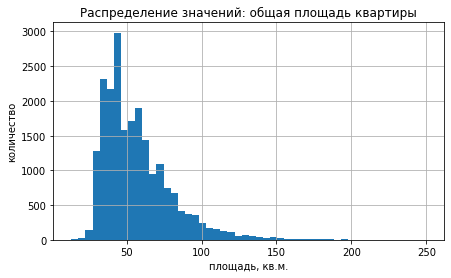

In [95]:
data['total_area'].hist(bins=50, figsize=(7,4))
plt.title('Распределение значений: общая площадь квартиры')
plt.xlabel('площадь, кв.м.')
plt.ylabel('количество')
plt.show()

**В архиве чаще всего встречаются квартиры, у которых жилая площадь составляет около 19 кв.м, что логично, поскольку самой многочисленной группой квартир в выборке являются однокомнатные. Вторая по численности группа квартир имеет жилую около 30 кв.м. В 2 раза меньше квартир, жилая площадь которых составляет 40 кв.м. Меньше всего в архиве квартир с жилой площадью, превышающей 100 кв.м.**

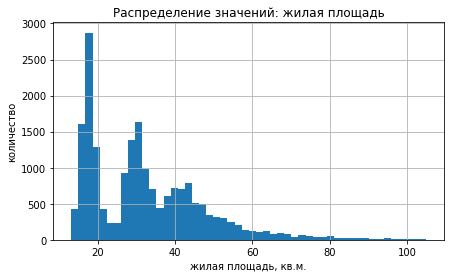

In [96]:
data['living_area'].hist(bins=50, figsize=(7,4))
plt.title('Жилая площадь')
plt.title('Распределение значений: жилая площадь')
plt.xlabel('жилая площадь, кв.м.')
plt.ylabel('количество')
plt.show()

**В архиве преобладают квартиры, в которых площадь кухни составляет около 8-9 кв.м.Также многочисленную группу составляют те объекты, в которых площадь квартиры равна 6 и 11 кв.м.**

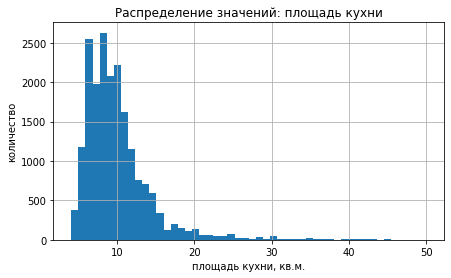

In [97]:
data['kitchen_area'].hist(bins=50, figsize=(7,4))
plt.title('Распределение значений: площадь кухни')
plt.xlabel('площадь кухни, кв.м.')
plt.ylabel('количество')
plt.show()

**Как видно, в выборке цена большинства квартир варьируется в районе 3.5-5 млн. рублей.**

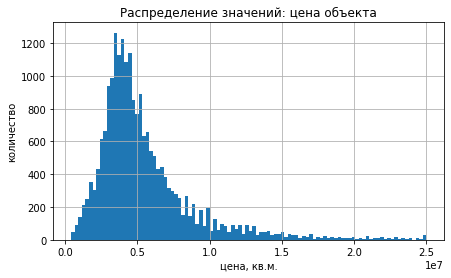

In [98]:
data['last_price'].hist(bins=100, figsize=(7,4))
plt.title('Цена объекта')
plt.title('Распределение значений: цена объекта'),
plt.xlabel('цена, кв.м.'),
plt.ylabel('количество'),
plt.show()

**Большинство квартир в архиве являются одно- и двухкомнатными. На 35% реже встречаются трехкомнатные квартиры,однако они тоже составляют значительную часть архива. Наименее распространены объекты с 4 комнатами и более.**

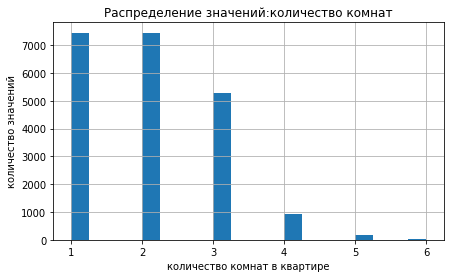

In [99]:
data['rooms'].hist(bins=20, figsize=(7,4))
plt.title('Распределение значений:количество комнат')
plt.xlabel('количество комнат в квартире')
plt.ylabel('количество значений')
plt.show()

**В архиве больше всего представлены квартиры,высота потолков которых составляет 2.7 м. Примерно равное количество квартир с высотой потолков, равной 2.4-2.6 м.**

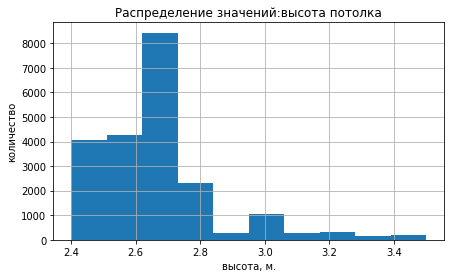

In [100]:
data['ceiling_height'].hist(bins=10, figsize=(7,4))
plt.title('Распределение значений:высота потолка')
plt.xlabel('высота, м.')
plt.ylabel('количество')
plt.show()

**В архиве преобладают квартиры, расположенные на нижних (до 5 включительно) этажах. На графике также видно, что количество квартир на 5-9, а также 10-15 и 14-16 этажах примерно одинаково. Меньше всего в архиве квартир, которые расположены на высоких  (19 и выше) этажах.**

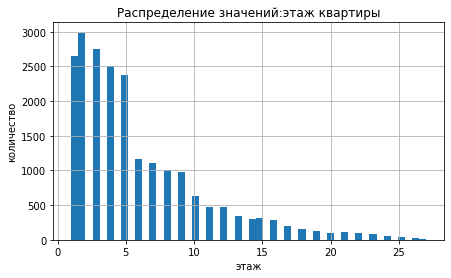

In [101]:
data['floor'].hist(bins=50, figsize=(7,4))
plt.title('Распределение значений:этаж квартиры')
plt.xlabel('этаж')
plt.ylabel('количество')
plt.show()

**В архиве преобладают квартиры, расположенные ни на первом, на на послежнем этажах. Их в 7 раз больше,чем тех, которые расположены на первом и последнем этажах.**

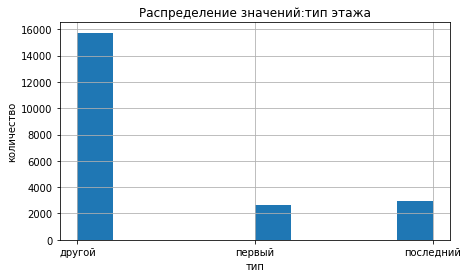

In [102]:
data['floor_type'].hist(bins=10, figsize=(7,4))
plt.title('Распределение значений:тип этажа')
plt.xlabel('тип')
plt.ylabel('количество')
plt.show()

**В архиве преобладают квартиры, расположенные в 5-этажных зданиях. Второй самой многочисленной группой являются квартиры в 9-этажных домах. Это можно объяснить тем, что 5- и 9-этажные здания в целом являются одними из самых распространенных.**

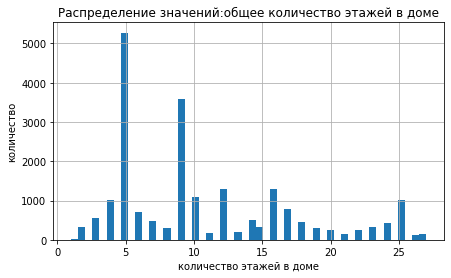

In [103]:
data['floors_total'].hist(bins=50, figsize=(7,4))
plt.title('Распределение значений:общее количество этажей в доме')
plt.xlabel('количество этажей в доме')
plt.ylabel('количество')
plt.show()

**В целом, на графике видно равномерное распределение значений расстояния до аэропорта.Большинство представленных в архиве квартир расположены в 11-40 км от аэропорта.**

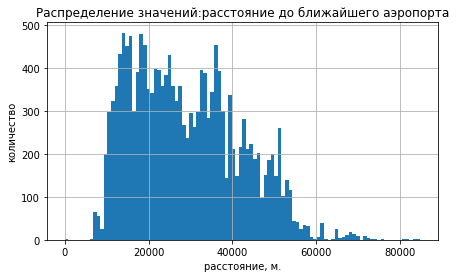

In [104]:
data['airports_nearest'].hist(bins=100, figsize=(7,4))
plt.title('Распределение значений:расстояние до ближайшего аэропорта')
plt.xlabel('расстояние, м.')
plt.ylabel('количество')
plt.show()

In [105]:
data['locality_name'].value_counts().head()

Санкт-Петербург    14056
поселок Мурино       489
поселок Шушары       411
Всеволожск           373
Пушкин               340
Name: locality_name, dtype: int64

**Большинство квартир расположены в 15 км от центра. Наблюдается равномерное распределение квартир, расположенных в 11-16 км от центра.Значительня часть объявлений также приходится на квартиры, расположенные в 4-6 км от центра.Это связано с тем, что на квартиры в Санкт-Петербурге и приближащие к нему населенные пункты (например, поселки Мурино и Шушары) приходится большинство всех объявлений.**

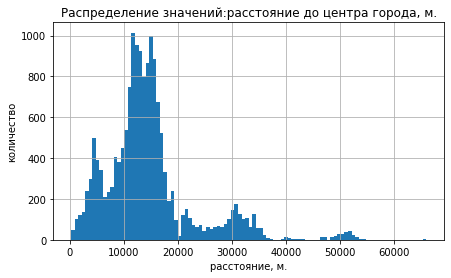

In [106]:
data['cityCenters_nearest'].hist(bins=100, figsize=(7,4))
plt.title('Распределение значений:расстояние до центра города, м.')
plt.xlabel('расстояние, м.')
plt.ylabel('количество')
plt.show()

**Большинство квартир расположены в 400-600 м от парка. Объекты, расположенные рядом или в 300 м от парка,являются второй по численности группой в архиве.Квартиры, которые находятся в 2 км и дальше от парка, составляют незначительную часть в общей выборке.**

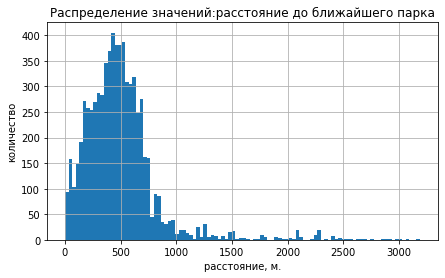

In [107]:
data['parks_nearest'].hist(bins=100, figsize=(7,4))
plt.title('Распределение значений:расстояние до ближайшего парка')
plt.xlabel('расстояние, м.')
plt.ylabel('количество')
plt.show() 

**В целом, наблюдается равномерное распределение в будние дни.Объявления реже публиковались в выходные.**

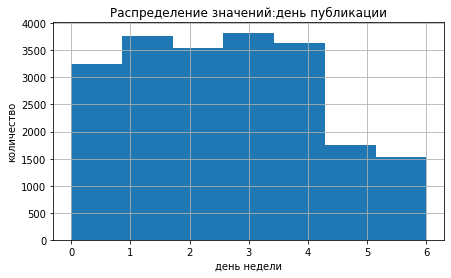

In [108]:
data['exposition_weekday'].hist(bins=7, figsize=(7,4))
plt.title('Распределение значений:день публикации')
plt.xlabel('день недели')
plt.ylabel('количество')
plt.show()

**Чаще всего объявления публиковались весной, реже всего - в мае и январе. В случае мая снижение числа публикаций можно связать с началом дачного сезона и сезона отпусков, а в случае января - недавним завершением новогодних празников.**

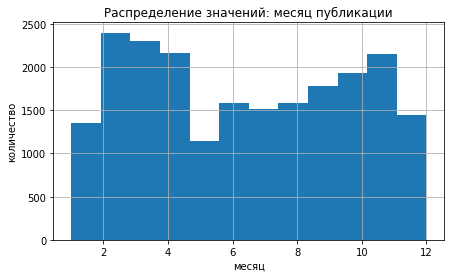

In [109]:
data['exposition_month'].hist(bins=12, figsize=(7,4))
plt.title('Распределение значений: месяц публикации')
plt.xlabel('месяц')
plt.ylabel('количество')
plt.show()

##### Изучение скорости продаж

**Изучим, как быстро продавались квартиры. Сначала построим гистограмму столбца 'days_exposition'.**

**Чаще всего продажа квартиры занимает около 45 дней.Столь резкое увеличение связано с тем, что по правилам Яндекс.Недвижимости объявления с квартирами стоимостью до 4.5 млн. рублей автоматически удаляются после 45 дней.
Необычно долгой продажей можно считать те ситуации, когда с момента публикации объявления до его снятия проходило более 800 дней, т.е. более 2 лет.**

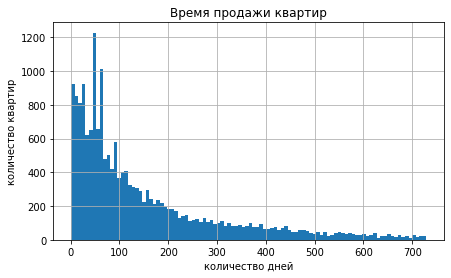

In [110]:
data['days_exposition'].hist(bins=100,figsize=(7,4))
plt.title('Время продажи квартир')
plt.xlabel('количество дней')
plt.ylabel('количество квартир')
plt.show()

**Посмотрим, есть ли в выборке еще резко выделяющиеся значения.**

**Второй по численности является группа квартир, у которых  в столбце 'days_exposition' указано 60 дней.Как раз столько времени на Яндекс.Недвижимости хранятся объявления с квартирами, чья стоимость оценивается в 4.5-10 млн. рублей. Также много объектов, объявления с которыми ми хранились на сайте ровно одну неделю или один месяц. Скорее всего, у этих квартир невысокая цена, и в связи с этим после установленного довольно короткого срока эти объявления автоматически были сняты.Большое количество количество объектов недвижимости, которые были на сайте ровно 90 дней: именно столько времени хранятся объявления домов. Значит,эти крупные значенияне не отражают, сколько в дейтсвительности потребовалось времени для продажи квартир.** 

In [111]:
data.days_exposition.value_counts().to_frame().head()

,days_exposition
45.0,820
60.0,526
7.0,218
30.0,194
90.0,172


**Посмотрим, сколько действительно в основном занимает продажа квартиры, увеличив число "верхних" значений до 15.**

**Как мы видим,скорее всего,чаще всего с момента публикации до его снятия проходит 3-20 дней.**

In [112]:
data.days_exposition.value_counts().to_frame().head(15)

,days_exposition
45.0,820
60.0,526
7.0,218
30.0,194
90.0,172
4.0,167
3.0,148
5.0,137
14.0,134
20.0,133


**Теперь используем метод .describe() для изучения статистической сводки столбца 'days_exposition' и, как следствие, получения,медианного значения, а метод .mean() - для нахождения среднего значения.**


In [113]:
data['days_exposition'].describe()


count    18458.000000
mean       149.455358
std        155.141230
min          1.000000
25%         43.000000
50%         90.000000
75%        203.000000
max        729.000000
Name: days_exposition, dtype: float64

In [114]:
data['days_exposition'].median()

90.00000000000001

**Среднее значение дней - это 174 дня. Медианное значение составляет 93 дня.**

**Посмотрим на изменение средней скорости продаж.**

**Сначала изучим количество значений в каждый год. Видим, что в 2014 г. продаж было немного. Если мы оставим этот год, то получим завышенное среднее значение. Чтобы избежать искажения данных, не будем рассматривать этот год в анализе.**

In [115]:
data.exposition_year.value_counts().to_frame()

,exposition_year
2018,8007
2017,7574
2019,2687
2016,2317
2015,691
2014,54


In [116]:
new_data = data.query('exposition_year > 2014')


**В каждом последющем году скорость продаж уменьшалась в 2 раза по сравнению с предыдущим.**

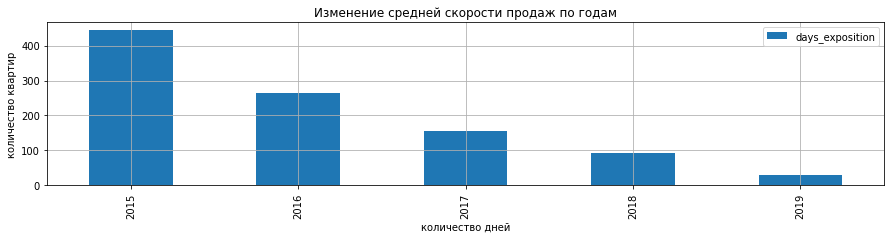

In [117]:
sales_dynamic_per_year = new_data.pivot_table(index='exposition_year', values='days_exposition')
sales_dynamic_per_year.plot(figsize=(15,3), kind='bar',grid=True);
plt.title('Изменение средней скорости продаж по годам')
plt.xlabel('количество дней')
plt.ylabel('количество квартир')
plt.show()

##### Анализ факторов, влияюищх на стоимость объекта

**На графике видно, что по мере возрастания общей площади квартиры растет и её стоимость.**

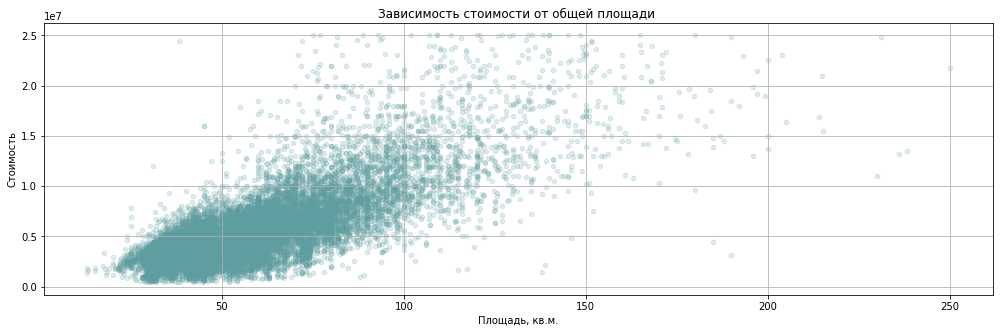

In [118]:
data.plot(x='total_area', y='last_price', kind='scatter', grid=True, c='cadetblue', alpha=0.2, figsize=(17, 5));

plt.title('Зависимость стоимости от общей площади ')
plt.xlabel('Площадь, кв.м.')
plt.ylabel('Стоимость')
plt.show()





**Коэфицент корреляции составляет 0.77: взаимосвязь между стоимостью и общей площадью есть, но она не очень сильна.**

In [119]:
data['last_price'].corr(data['total_area']) #рассчитаем коэфицент корреляции между стоимостью и общей площадью квартиры

0.7723666716682851

**Аналогично общей площади, жилая площадь влияет на стоимость объекта недвижимости. Чем больше жилая площадь, тем выше цена.Однако в выборке также встречаются квартиры, которые в несколько раз дороже, чем в среднем объекты недвижимости в такой же жилой площадью.**

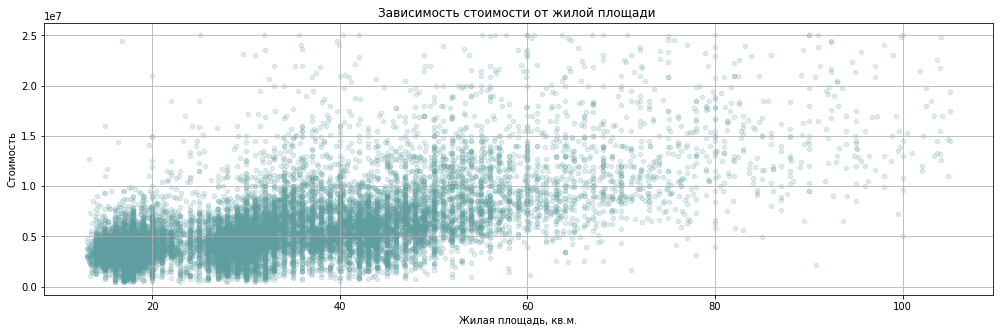

In [120]:
data.plot(x='living_area', y='last_price', kind='scatter', c='cadetblue', alpha=0.2, grid=True, figsize=(17, 5));

plt.title('Зависимость стоимости от жилой площади ')
plt.xlabel('Жилая площадь, кв.м.')
plt.ylabel('Стоимость')
plt.show();


**Рассчитав коэфицент корреляции, мы убедились в том,что связь между стоимостью и жилой площадью имеется, но не очень сильная.**

In [121]:
data['last_price'].corr(data['living_area']) 

0.6493360193490504

**На графике видно постепенное подорожание квартир по мене увеличения площади кухни в них.При этом данная зависимость носит, скорее, ограниченный характер, поскольку мы видим наличие объектов, которые в несколько раз дороже объектов с такой же площадью кухни(5-30 кв.м.) Поскольку ранее аномальные значения были удалены, мы не можем говорить о том, что отображенное эпизодические повышение цены связано с вбросами. Скорее всего, так отображаются квартиры в исторических районах Петербурга: у них небольшая площадь кухни и высокая цена.**

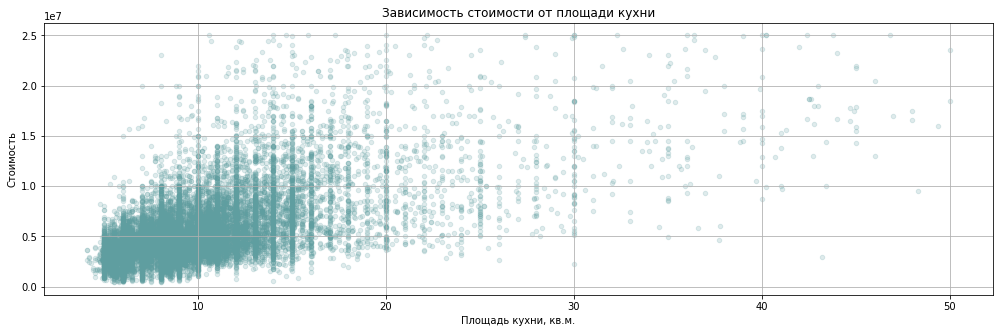

In [122]:
data.plot(x='kitchen_area',y='last_price', kind='scatter', grid=True, c='cadetblue', alpha=0.2, figsize=(17, 5));
plt.ylabel('Стоимость')
plt.xlabel('Площадь кухни, кв.м.')
plt.title('Зависимость стоимости от площади кухни')
plt.show()

**Коэффицент корреляции также указывает на то, что связь хоть и есть, но она не достаточно сильная.**

In [123]:
data['last_price'].corr(data['kitchen_area']) 

0.6051705762847678

**Изучим взаимосвязь между количеством комнат в квартире и ценой на нее. Зависимость между двумя факторами есть, но она носит не однозначный характер. С одной стороны, происходит подоражание квартир, если в них 2, 3, 4, 5, 6 и комнат.**

**Посмотрим на зависимость стоимости от количества комнат. На графике видно, что связь есть, но носит ограниченный характер. Действительно, однокомнатные квартиры  стоят меньше, чем двукомнатные; а последние стоят меньше, чем трехкомнатные. При этом, однако,  на графике видно, что концентрация "верхних" значений у трехкомнатных квартир выше, чем у четырех-, пяти- и шестикомнатных.**

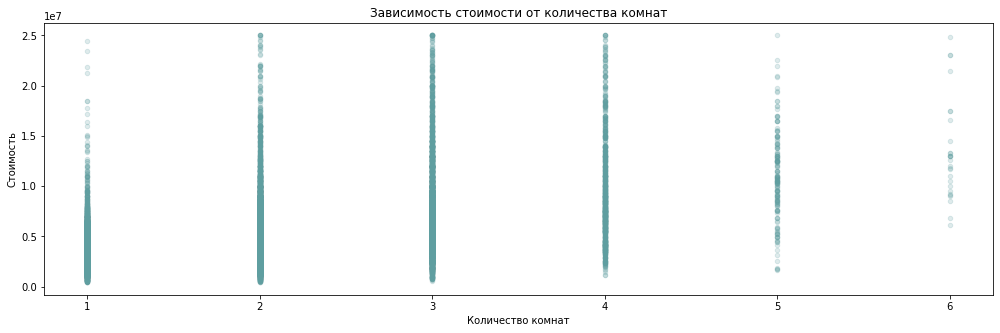

In [124]:
data.plot(x='rooms', y='last_price', kind='scatter', c='cadetblue', alpha=0.2,figsize=(17, 5))
plt.xlabel('Количество комнат')
plt.ylabel('Стоимость')
plt.title('Зависимость стоимости от количества комнат')
plt.show()

In [125]:
data['last_price'].corr(data['rooms']) 

0.47455467891450553

**Посмотрим на зависимость стоимости на квартиру от высоты её потолка. Как мы видим, она носит спорный характер. Наличие резкиого роста и снижения на графике нельзя объяснить аномалиями, так как мы от них избавились. В целом,цены на квартиры с высотой потолка 2.7 м не сильно отличаются от цен на квартиры, в которых высота потолка составляет 3 м.При этом мы наблюдаем падение цены для квартир с высотой потолков около 3.2 м.Происходит снижение стоимости  квартир с потолками выше 3.3 м: это могут быть квартиры в старых домах, в частности в исторических районах Петербурга, однако в теории такие объекты недвжиимости должны наоборот стоит дороже в силу своего местоположения.**

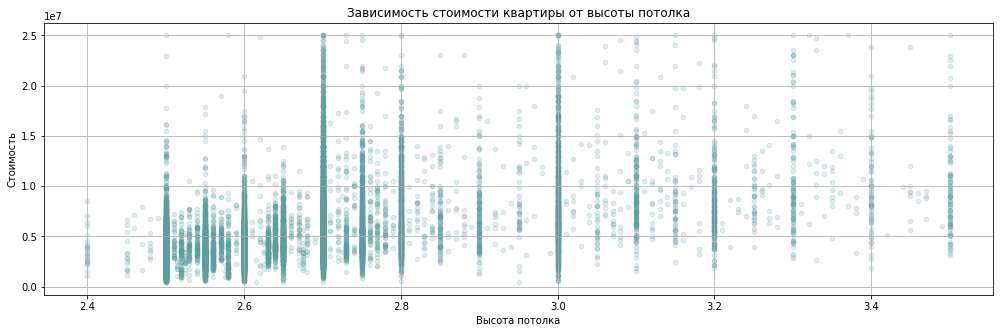

In [126]:
data.plot(x='ceiling_height', y='last_price',kind='scatter', grid=True,figsize=(17, 5), c='cadetblue', alpha=0.2)
plt.xlabel('Высота потолка')
plt.ylabel('Стоимость')
plt.title('Зависимость стоимости квартиры от высоты потолка')
plt.show()

In [127]:
data['last_price'].corr(data['ceiling_height'])

0.4476584272575126

**Таким образом, удалось установить, что на стоимость объекта недвижимости в наибольшей степени влияет его общая площадь, в наименьшей - высота потолков в нем.**

**Перейдем к зависимости  средней цены от типа этажа. Наблюдается значительная разница в цене между квартирами, расположенными на первомм этаже и на остальных(не учитывая последний).В среднем квартиры, расположенные на последнем этаже, на 700 тыс. дороже по сравнению с теми, которые на первом. При этом та же категория квартир стоит на 600 тыс. дешевле, чем те,которые расположены на других этажах.**

**Как видно на графике ниже, за исследуемый период квартиры, расположенные либо на первом,либо на последнем этажах, продавались в 4 раза реже чем объекты недвижимости, расположенные на остальных этажах.**

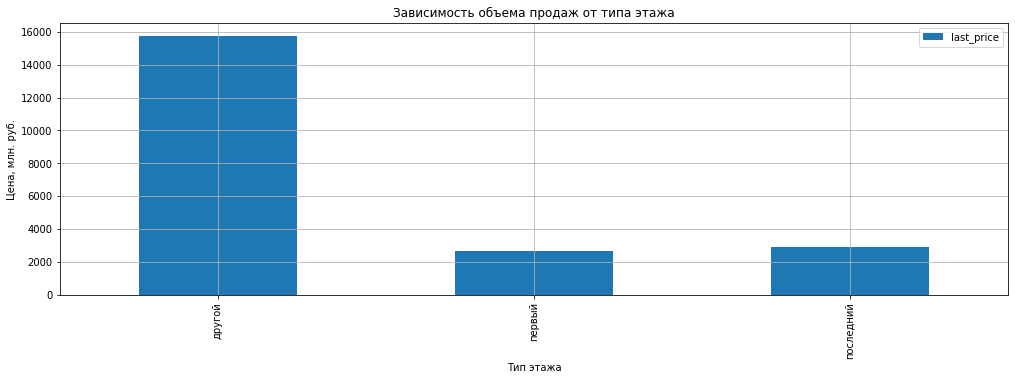

In [128]:
(
    data.pivot_table(index='floor_type', values='last_price', aggfunc='count')
    .plot(grid=True,kind='bar',figsize=(17, 5))
) 
plt.xlabel('Тип этажа')
plt.ylabel('Цена, млн. руб.')
plt.title('Зависимость объема продаж от типа этажа')
plt.show()

**Перейдем к анализу зависимости общей стоимости объекта от даты размещения объявления. В начале сгруппируем данные по дням недели и посмотрим на взаимосвязь между объемом продаж и днем недели. На графике видно, что продажи достигают пика во вторник и четверг. В выходные происходит резкое снижение (более чем в 2 раза) снижение объема продаж.**

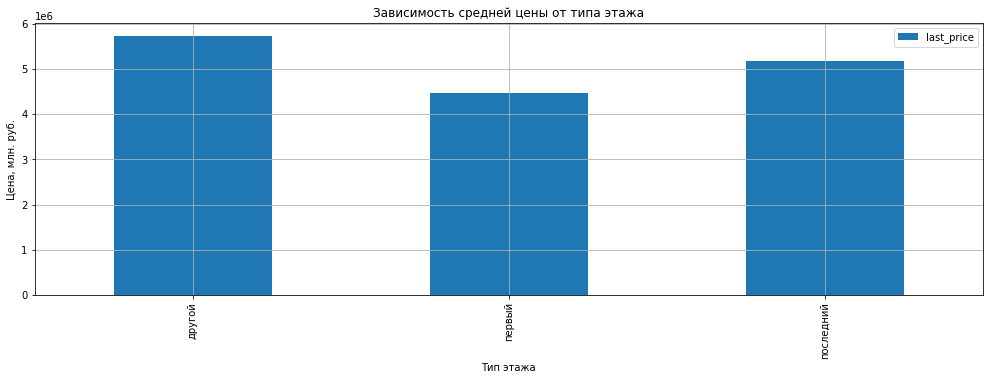

In [129]:
(
    data.pivot_table(index='floor_type', values='last_price')
    .plot(grid=True,kind='bar',figsize=(17, 5))
) 
plt.xlabel('Тип этажа')
plt.ylabel('Цена, млн. руб.')
plt.title('Зависимость средней цены от типа этажа')
plt.show()

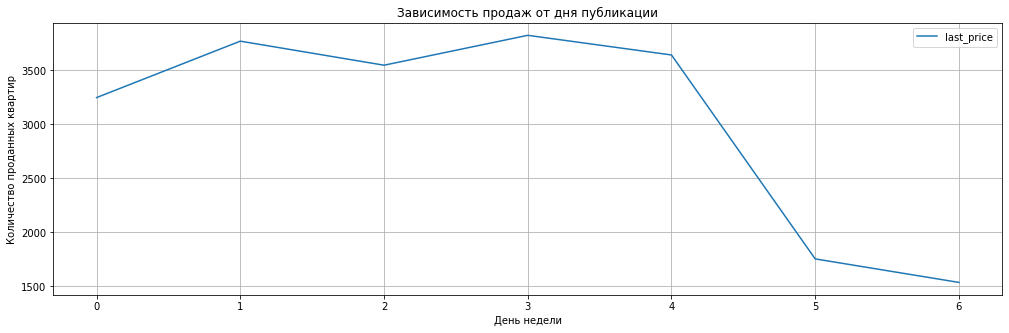

In [130]:
(
    data.pivot_table(index='exposition_weekday', values='last_price', aggfunc='count')
    .plot(y='last_price', grid=True,figsize=(17, 5))
) 
plt.xlabel('День недели')
plt.ylabel('Количество проданных квартир')
plt.title('Зависимость продаж от дня публикации')
plt.show();

In [131]:
data['last_price'].corr(data['exposition_weekday']) #находим коэфицент корреляции между днем публикации и стоимостью квартиры 

-0.012406107334524425

**Как видно на отображенном ниже графике, самые дорогие квартиры публикуются в четверг. В будние дни наблюдается тенденция к снижению стоимости публикуемых квартир несмотря на то, что в среду средняя стоимость выставленных квартир выше чем в прыдудщие дни. Публикация объявлений с наиболее высокой стоиомостью наблюдается в выходные дни,достигая пика в субботу. При этом уже на следующий день, в воскресенье, происходит резкое и существенное снижение стоимости: по своему масштабу оно превосходит резкое увеличение стоимости днем ранее.**

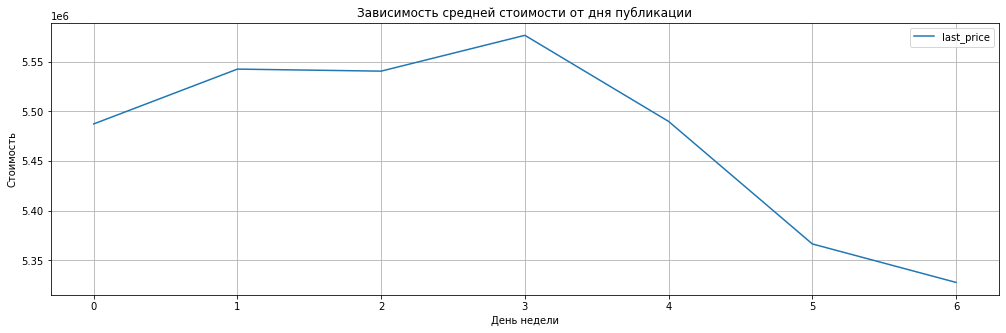

In [132]:
(
    data.pivot_table(index='exposition_weekday', values='last_price')
    .plot(y='last_price', grid=True,figsize=(17, 5))
) 
plt.xlabel('День недели')
plt.ylabel('Стоимость')
plt.title('Зависимость средней стоимости от дня публикации')
plt.show();

**Изучим зависимость объема продаж от месяца. Как видно на графике, пик продаж приходится на февраль. В мае происходит их резкое падение, однако уже в июне оно немного компенсируется возобновившимся ростом.До ноября продолжается рост, и в декабре снова происходит резкий спад продаж.**

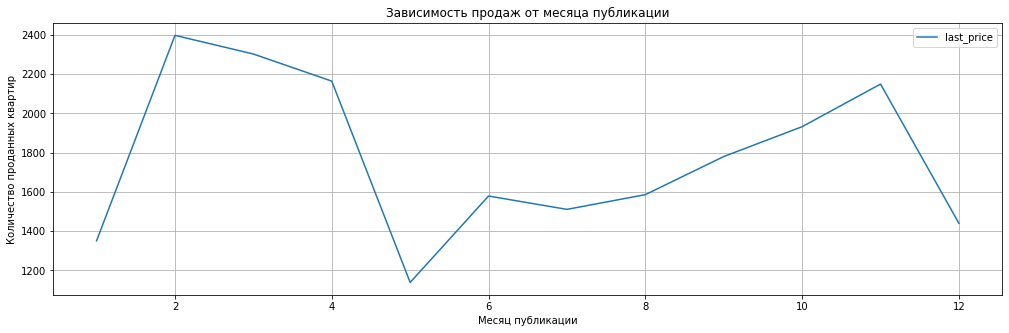

In [133]:
(
    data.pivot_table(index='exposition_month', values='last_price', aggfunc='count')
    .plot(y='last_price', grid=True,figsize=(17, 5))
) 
plt.xlabel('Месяц публикации')
plt.ylabel('Количество проданных квартир')
plt.title('Зависимость продаж от месяца публикации')
plt.show();

**Рассчитав коэфицент корреляции, мы убеждаемся в том, что месяц практически не влияет на стоимость объекта.**

In [134]:
data['last_price'].corr(data['exposition_month']) 

-0.001346520294141064

**Перейдем к анализу зависимости между месяцем публикации и средней стоимостью опубликованной квартиры. Как видно на графике, нет устойчивого тренда: нельзя выявить зависимость между сезоном/месяцем и стоимостью квартиры. Например, происходит резкое снижение стоимости как в теплое время года (июнь), так и в холодное (октябрь). Однако наблюдается существенный рост общей  стоимости в сентябре, т.е. по завершении сезона отпусков.**

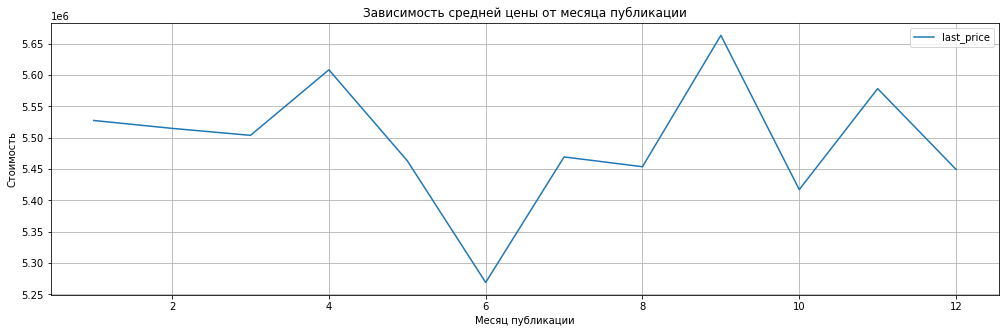

In [135]:
(
    data.pivot_table(index='exposition_month', values='last_price')
    .plot(y='last_price', grid=True,figsize=(17, 5))
) 
plt.xlabel('Месяц публикации')
plt.ylabel('Стоимость')
plt.title('Зависимость средней цены от месяца публикации')
plt.show();

**Теперь посмотрим на зависимость между годом публикации и  средней стоимостью квартир. Пик цен пришелся на 2015 год. В 2016 г. произошло резкое снижение средней стоимости. В 2017 г. падение продолжилось, однако его темпы значительно снизились. Последующие 2 года (2018-2019 гг.) наблюдалось постепенное повышение стоимости на 100-200 тыс. рублей за полугодие.**  

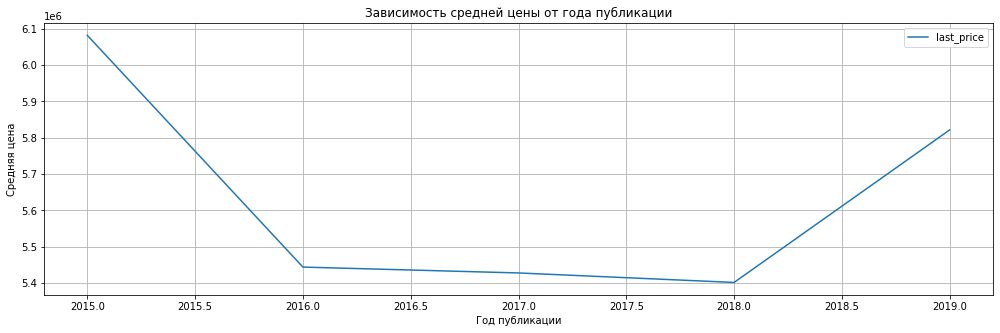

In [136]:
(
    new_data.pivot_table(index='exposition_year', values='last_price')
    .plot(y='last_price',grid=True,figsize=(17, 5))
) 
plt.xlabel('Год публикации')
plt.ylabel('Средняя цена')
plt.title('Зависимость средней цены от года публикации')
plt.show()

**На протяжении 2015-2016 гг. наблюдался рост объема продаж.В 2017 г. он продолжился, однако его темпы существенно снизились. В 2018 г. произошло резкое снижение объемов продаж: оно продолжалось до самого начала 2019 г.**

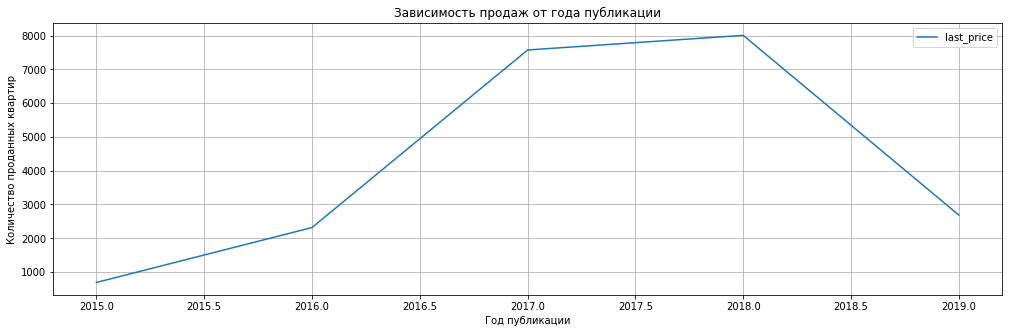

In [137]:
(
    new_data.pivot_table(index='exposition_year', values='last_price',aggfunc='count')
    .plot(y='last_price',grid=True,figsize=(17, 5))
) 
plt.xlabel('Год публикации')
plt.ylabel('Количество проданных квартир')
plt.title('Зависимость продаж от года публикации')
plt.show();

**Коэффицент корреляции указывает на то, что год практически не влияет на стоимость.**

In [138]:
data['last_price'].corr(data['exposition_year']) 

-0.005452872167517997

**Теперь узнаем минимальную и максимальную стоимость квадратного метра.**

In [139]:
data['price_per_square_metre'].min() 


9615.0

**Посредством создания среза данных удалось выяснить, что населенным пунктом с самой низкой стоимостью квадратного метра являются Сланцы.**

In [140]:
min_price_per_square_metre = 9615.0 #присвоим переменной минимальное значение в столбце с ценами за квадратный метр 
min_price_locality = data.query('price_per_square_metre == @min_price_per_square_metre')
min_price_locality['locality_name'].unique()

array(['Сланцы'], dtype=object)

In [141]:
data['price_per_square_metre'].max() #максимальнаяя стоимость 1 кв.м. 

640422.0

**Как видно ниже, объект с самой высокой стоимостью за квадратный метр располжен в Всеволожске.**

In [142]:
max_price_per_square_metre = 640422.0 #присвоим переменной максимальное значение в столбце с ценами за квадратный метр 
max_price_locality = data.query('price_per_square_metre == @max_price_per_square_metre')
max_price_locality['locality_name'].unique()

array(['Всеволожск'], dtype=object)

##### Изучение 10 населенных пунктках с наибольшим количеством объявлений

**Теперь обратимся к данным 10 населенных пунктов с наибольшим числов опубликованных объектов недвижимости.**

In [143]:
top_ten_data = data['locality_name'].value_counts().head(10)

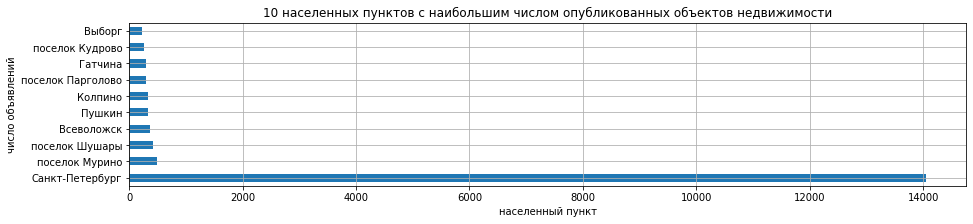

In [144]:
top_ten_data.plot(figsize=(15,3), kind='barh', grid=True)
plt.title('10 населенных пунктов с наибольшим числом опубликованных объектов недвижимости')
plt.xlabel('населенный пункт')
plt.ylabel('число объявлений')
plt.show();


**Посчитаем стоимость 1 кв. м. в 10 населенных пунтах с наибольшим количеством объявлений. В выборке населенным объектом с минимальной стоимостью одного квадратногометра является Выборг, а с максимальной - Санкт-Петербург.**

In [145]:
(
    data.query('locality_name in ["Санкт-Петербург", "поселок Мурино", "поселок Шушары", "Всеволожск", "Пушкин", "Колпино", \
                "Гатчина","поселок Парголово","поселок Кудрово", "Выборг"]')
     .groupby('locality_name')['price_per_square_metre']
     .agg(['mean'])
     .style.format("{:,.0f}")
)


,mean
locality_name,
Всеволожск,"68,689"
Выборг,"58,002"
Гатчина,"69,179"
Колпино,"75,254"
Пушкин,"101,864"
Санкт-Петербург,"109,212"
поселок Кудрово,"92,350"
поселок Мурино,"84,838"
поселок Парголово,"89,792"


**Обратимся к столбцу с данными о расстоянии объекта в км до центра города. Посредством создания сводной таблицы удалось визуализировать зависимость стоимости квартиры от её месторасположения. Наиболее дорогие квартиры расположены в 0-5 км от центра города, в то время как самые доступные объекты недвижимости расположены в 20-40 км от центра. При этом стоит отметить, что  расположенные в 42-43 км до центра города объекты имеют почти такую же стоимость,  что и те, которые расположены в 8 км. Также стоимость объектов, расположенных в 55 км от центра,  в 2 раза выше, чем тех, которые расположены в 42-54 км. Скорее всего, так на графике отображены данные об объектах недвжимости в элитных загородных поселках.** 

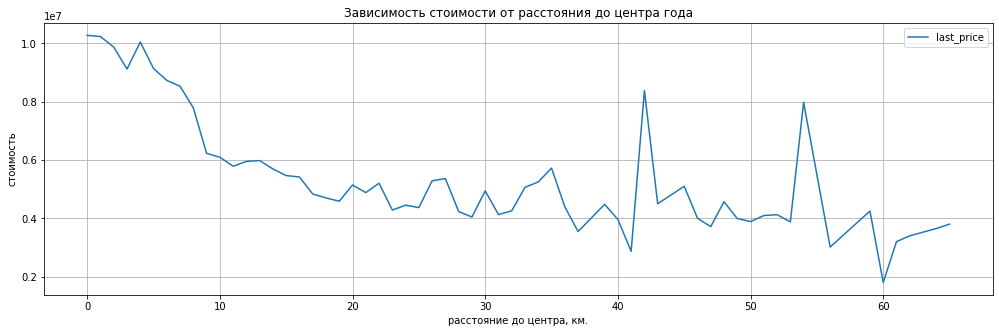

In [146]:
(
    data.pivot_table(index='cityCenters_nearest_km', values='last_price')
    .plot(grid=True, figsize=(17, 5))
)
plt.title('Зависимость стоимости от расстояния до центра года')
plt.xlabel('расстояние до центра, км.')
plt.ylabel('стоимость')
plt.show();


**Рост стоимости квартиры связан с уменьшением расстояния до центра.**

In [147]:
data['last_price'].corr(data['cityCenters_nearest_km']) #находим корреляцию между расстоянием до центра города и стоимостью

-0.3368965767319636

##### Изучение зависимости стоимости объектов  от расстояния до центра Санкт-Петербурга

**Изучим зависимость между стоимостью объектов недвижимости в Санкт-Петербурге и их расстояниями до центра города.**

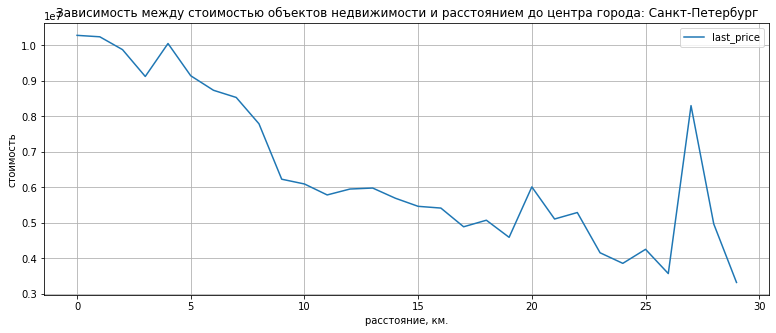

In [148]:
spb_info = data.loc[(data['locality_name'] == 'Санкт-Петербург')]
spb_info_km_data = spb_info.pivot_table(index='cityCenters_nearest_km', values='last_price')
spb_info_km_data.plot(y='last_price',grid=True, figsize=(13,5))
plt.title('Зависимость между стоимостью объектов недвижимости и расстоянием до центра города: Санкт-Петербург')
plt.xlabel('расстояние, км.')
plt.ylabel('стоимость')
plt.show();



**Есть пик ипадение на отрезке 3-5 км. Изучим природу резкого изменения цен.**

In [149]:
spb_info.shape[0]

14056

In [150]:
spb_info.cityCenters_nearest_km.value_counts().to_frame()

,cityCenters_nearest_km
12.0,1451
14.0,1443
11.0,1337
13.0,1324
15.0,1316
16.0,1058
10.0,860
4.0,671
9.0,642
8.0,597


In [151]:
three_km = spb_info.loc[(spb_info['cityCenters_nearest_km'] == 3)]
three_km.shape[0]

405

In [152]:
#рассчитаем долю объектов недвижимости, расположенных в 3 км от центра Петербурга, от всех квартир в городе
426/14591 *100

2.9196079775203896

In [153]:
three_km.total_area.mean()

79.79651851851852

In [154]:
five_km = spb_info.loc[(spb_info['cityCenters_nearest_km'] == 5)]
five_km.shape[0]


566

In [155]:
#рассчитаем долю объектов недвижимости, расположенных в 5 км от центра Петербурга, от всех квартир в городе
608/14591 *100

4.166952230827222

**Сравним общую площадь объектов недвижимости, расположенных в 3 и 5 км до центра.У объектов недвижимсоти, расположенных в 3 км до центра общая площадь в среднем на 8 кв. м. больше чем в тех, которые расположены в 5 км. до центра. Таким образом, пик и резкий спад можно объяснить различиями в средней площади квартир.**

In [156]:
# способы группировки и сортировки информации

(
    data.loc[(data['locality_name'] == 'Санкт-Петербург')]
     .query('3 <= cityCenters_nearest_km <=5 ')
     .groupby(['cityCenters_nearest_km', 'floor_type'])['last_price']
     .agg(['count', 'mean'])
     .style.format("{:,.0f}")
)

In [157]:
three_km.total_area.mean() 


79.79651851851852

In [158]:
five_km.total_area.mean()

72.59773851590106

In [159]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21330 entries, 0 to 23697
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            21330 non-null  int64         
 1   last_price              21330 non-null  int64         
 2   total_area              21330 non-null  float64       
 3   first_day_exposition    21330 non-null  datetime64[ns]
 4   rooms                   21330 non-null  int64         
 5   ceiling_height          21330 non-null  float64       
 6   floors_total            21330 non-null  int64         
 7   living_area             19625 non-null  float64       
 8   floor                   21330 non-null  int64         
 9   is_apartment            21330 non-null  bool          
 10  studio                  21330 non-null  bool          
 11  open_plan               21330 non-null  bool          
 12  kitchen_area            19490 non-null  float6

**На графике наблюдается резкое повышение цены на квартиры,расположенные в 27 км от центра Петербурга. Пик может быть следствием небольшого количества значений, удовлетворяющих заданному условию, в следствие чего среднее значение цены завышено.**

**Квартир,расположенных в 27 км от центра города, всего 2. Таким образом, пик связан с ограниченным числом значений.**

In [160]:
spb_info.loc[(spb_info['cityCenters_nearest_km'] == 27)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_metre,exposition_weekday,exposition_month,exposition_year,floor_type,cityCenters_nearest_km
748,13,14350000,74.0,2017-11-28,2,3.13,5,30.0,3,True,...,1496.0,0,NaN,128.0,193918.0,1,11,2017,другой,27.0
5961,6,2250000,32.0,2018-02-27,1,2.70,2,16.5,2,True,...,NaN,0,NaN,178.0,70312.0,1,2,2018,последний,27.0


### Общий вывод

Для того, чтобы изучить рынок недвижимости в Санкт-Петербурге и Ленинградской области, в исследовании были предриняты следующие шаги:

    1)предобработка данных, включавшаяся в себя выявление пропусков в значениях и заполнение их при помощи 
    логической индексации, а также удаление аномальных значений и изменение типа данных в нескольких столбцах;
    
    2)добавление в таблицу новых столбцов для того, чтобы углубить исследование закономерностей на рынке недвижимости;
    
    3)составление гистограмм для исследования особенностей распределения значений и, как следствие, понимания,
    данные о каких категориях квартир в большей степени влияют на формирование трендов на рынке недвижимости региона; 
    
    4)визуализация зависимости цены квартиры от её различных характеристик посредством создания сводных таблиц и 
    построения графиков;
    
    5)выявление населенных пунктво с самой низкой и самой высокой стоимостью квадратного метра;
    
    6)использование среза даннных для выявления населенных пунктов с самой низкой и высокой стоимостью квадратного метра.
    
Вышеописанный алгоритм действий позволил выявить ряд закономерностей на рынке недвижимости Санкт-Петербурга и Ленинградской обалсти. Во-первых, по мере повышения как общей, так и жилой площади квартир происходит их подорожание. Во-вторых, наблюдается значительная разница в стоимсти между объектами, распложенными на первом и последнем этажах по сравнению с остальными этажами. В-третьих, существует связь между временем, когда публикуются объявления и средней ценой квартир. Например,квартиры, опубликованные в начале рабочей недели, стоят меньше, чем те, которые были выставлены в конце рабочей недели и в выходные. Также в период с 2015-2018 гг. наблюдалось снижение стоимости квартир.В целом, удалось установить, что в наибольшей мере на стоимость объекта влияет его общая площадь. Помимо этого, чем ближе объект недвижмости расположен к центру, тем дороже он стоит. Также была выявлена сильная корреляция между днем публикации объекта недвжимости и его стоимостью: самые дорогие объекты публикуются в середине недели, а самые доступные - в выходные. В наименьшей мере на стоимость объекта влияет высота потолков.

Однако, посредством визуализации данных также удалось, что ряд закономерностей на рынке недвижимости носит спорный характер. Так, тенденция повышения цены на квартиру в зависимости от количества квартир в ней носит спорный характер. Также несмотря на то, что в целом прослеживается тенденция повышения стоимости квартиры по мере увеличения площади кухни в ней, есть объекты недвижимости, которые не вписываются в данную динамику, так как их цена значительно выше по сравнению с другими объектами с такой же площадью. Аналогичный тренд был выявлен при изучении зависимости между ценой квартиры и высотой потолков в ней. В дополнение к этому, при изучении корреляции между ценой и расстоянием от центра города была доказано, что чем ближе квартира расположена к центру, тем она дороже, однако, некоторые объекты, расположенные в 42-43 и 54 км от центра города, имеют почти такую же стоимость, что и те, которые расположены в 6-7 км. 

Эти выводы указывают на то, что при анализе корреляции двух факторов необходимо учитывать существование третьих.В этом удалось убедиться, проанализировав стоимость квартир в Петербурге и их расстояние до центра города: объекты недвижимости, расположенные в 3 км. до центра, в среднем на 8 кв.м. больше чем те, которые расположены в 5 км. до центра. Также при анализе важно брать во внимание тот факт, что некоторые квартиры относятся к люксовому сегменту рынка недвижимости или расположены в исторических зданиях.